In [ ]:
%matplotlib inline

# path hack for relative import in jupyter notebook
import os
import sys
import time

# LIBRARY GLOBAL MODS
CELLTYPES = os.path.dirname(os.path.abspath(''))
sys.path.append(CELLTYPES)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import pandas as pd
import umap
import time
%matplotlib inline

sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})

In [ ]:
from matplotlib.colors import ListedColormap, BoundaryNorm, NoNorm, Normalize
from matplotlib.colorbar import ColorbarBase
from matplotlib.cm import get_cmap, ScalarMappable

In [ ]:
# need to set cmaps to be used before importing multicell_replot 
#   as it uses proplot which modifies matplotlib

CMAP_SPECTRALR = get_cmap('Spectral_r')
GLOBAL_DPI = 450

In [ ]:
from utils.file_io import RUNS_FOLDER

In [ ]:
NOTEBOOK_OUTDIR = RUNS_FOLDER + os.sep + 'explore' + os.sep + 'nb_alignUMAP'
os.makedirs(NOTEBOOK_OUTDIR, exist_ok=True)

# TODO: Import reloading while retaining variables in memory

In [ ]:
#import importlib
#importlib.reload(multicell.multicell_replot)

#import inspect
#print(inspect.getsource(multicell.multicell_replot.replot_scatter_dots))

# Functions: Non-Plotting

In [ ]:
def reshape_totalspins(tallstate, num_cells, num_genes):
    widestate = tallstate.reshape((num_genes, num_cells), order='F')
    return widestate

In [ ]:
def build_X_multi(manyruns_paths, subsample_ndim=None, subsample_ensemble=None, smod_last=True, use_01=True):
    # any asserts and simple variable settings
    if smod_last:
        smod = '_last' # oldstyle
    else:
        smod = ''      # newstyle
    
    # get data dimensionality and set system size variables
    ref_fpath_state = manyruns_paths[0] + os.sep + 'aggregate' + os.sep + 'X_aggregate%s.npz' % smod
    ref_X = np.load(ref_fpath_state)['arr_0'].T  # umap wants transpose
    npts, ndim = ref_X.shape
    print("npts, ndim", npts, ndim)
    
    if subsample_ensemble is not None:
        assert 0 < subsample_ensemble <= npts
        nn = subsample_ensemble
    else: 
        nn = npts
        
    if subsample_ndim is not None:
        assert 0 < subsample_ndim <= ndim
        kk = subsample_ndim
    else:
        kk = ndim
    
    # Step 1: generate X_multi
    X_multi = np.zeros((len(manyruns_paths), nn, kk), dtype=int)
    for j, manyruns_path in enumerate(manyruns_paths):

        #gamma_val = gamma_list[j]

        agg_dir = manyruns_path + os.sep + 'aggregate'
        fpath_state = agg_dir + os.sep + 'X_aggregate%s.npz' % smod
        fpath_energy = agg_dir + os.sep + 'X_energy%s.npz' % smod
        fpath_pickle = manyruns_path + os.sep + 'multicell_template.pkl'

        X = np.load(fpath_state)['arr_0'].T  # umap wants transpose
        X_energies = np.load(fpath_energy)['arr_0'].T  # umap wants transpose (?)
        with open(fpath_pickle, 'rb') as pickle_file:
            multicell_template = pickle.load(pickle_file)  # unpickling multicell object

        #print('accessing', j, manyruns_path)
        X_multi[j, :, :] = X[0:nn, 0:kk]
    
    if use_01:
        X_multi = (1 + X_multi) / 2.0
        X_multi = X_multi.astype(int)
        
    num_cells = multicell_template.num_cells
    num_genes = multicell_template.num_genes
    return X_multi, num_cells, num_genes


def gather_data_then_alignedUMAP(
    manyruns_paths, manyruns_dirnames, umap_kwargs, 
    skip_alignment=False, subsample_ndim=None, subsample_ensemble=None, 
    smod_last=True, use_01=True):
    """
    All of these arguments are prepared in a dictionary 
        settings_aligned_umap_fig5_v1
        settings_aligned_umap_fig5_v2
        etc.
    and chosen later in the notebook settings_alignment_chosen
    """
    # TODO once this fn done, need to propogate data_subdict object through nb
    #  - it should replace aligned_mapper
    #  - should also integrate it with alignment settings dict somehow
    # TODO should have class or validation function for data_subdict init
    # TODO integrate side data like num unqieu states (analagous to energy)
    
    if smod_last:
        smod = '_last'
    else:
        smod = ''

    def build_data_subdict_from_alignedUMAP(data_subdict, X, embedding):
        """
        data_subdict: partially complete data_subdict (path and label keys)
        X:            raw data 2d arr (num_runs x num_dimensions)
        embedding:    embedded data (num_runs x num_lowdim)
        """
        # Reload data_subdict source files
        #  note: we transpose raw data, energies for umap/other functions
        manyruns_path = data_subdict['path']
        agg_dir = manyruns_path + os.sep + 'aggregate'
        fpath_state = agg_dir + os.sep + 'X_aggregate%s.npz' % smod
        fpath_energy = agg_dir + os.sep + 'X_energy%s.npz' % smod
        fpath_pickle = manyruns_path + os.sep + 'multicell_template.pkl'
        X = np.load(fpath_state)['arr_0'].T          
        X_energies = np.load(fpath_energy)['arr_0'].T
        with open(fpath_pickle, 'rb') as pickle_file:
            # unpickling multicell object
            multicell_template = pickle.load(pickle_file)  
        
        # Fill out the rest of data_subdict keys        
        num_runs, total_spins = X.shape
        data_subdict['data'] = X
        data_subdict['index'] = list(range(num_runs))
        data_subdict['energies'] = np.round(X_energies, decimals=6)
        data_subdict['num_runs'] = num_runs
        data_subdict['total_spins'] = total_spins
        data_subdict['multicell_template'] = multicell_template
        data_subdict['algos'] = {
            'umap': 
                {'reducer': None,
                 'embedding': embedding}
        }

        # Add extra analysis data used within the notebook
        X_nunique = get_unique_states_over_ensemble(
            X, 
            multicell_template.num_cells, 
            multicell_template.num_genes
        )
        data_subdict['nunique'] = X_nunique.T  # note transpose
        assert (
            data_subdict['energies'].shape[0] == 
            data_subdict['nunique'].shape[0])
        
        return data_subdict
    
    # Step 0: any asserts and simple variable settings
    assert 'random_state' in umap_kwargs.keys()
    
    # Step 1: construct X_multi (tensor of tissue state ensembles)
    X_multi, _, _ = build_X_multi(
        manyruns_paths, 
        subsample_ndim=subsample_ndim, 
        subsample_ensemble=subsample_ensemble, 
        smod_last=smod_last, 
        use_01=use_01
    )
    nn = X_multi.shape[1]
    
    # Step 2: perform alignedUMAP
    aligned_mapper = umap.AlignedUMAP(**umap_kwargs)
    
    if skip_alignment:
        print('Warning - skipping alignment step...')
        mappers = [
            umap.UMAP(**umap_kwargs).fit(X_multi[n, :, :])
            for n in range(len(manyruns_paths))
        ]
        embeddings = [mappers[n].embedding_ for n in range(len(manyruns_paths))]
        aligned_mapper.embeddings_ = embeddings
    else:
        # UMAP aligned needs a 'relation dict' for the 'time varying' dataset
        #   our relation is that each traj maps to itself (in time) -- constant relation
        constant_dict = {i: i for i in range(nn)}
        constant_relations = [constant_dict for i in range(len(manyruns_paths)-1)]
        print('Beginning AlignedUMAP...')
        aligned_mapper.fit(X_multi, relations=constant_relations)
        print('...done')
        
    # Step 3: Convert to data_subdict format
    # TODO - implement saving
    embedded_datasets = {i: {'label': manyruns_dirnames[i],
                             'path': manyruns_paths[i]}
                         for i in range(len(manyruns_dirnames))}
    
    for idx in range(len(manyruns_dirnames)):
        embedded_datasets[idx] = build_data_subdict_from_alignedUMAP(
            embedded_datasets[idx], 
            X_multi[idx,:,:], 
            aligned_mapper.embeddings_[idx]
        )
        #fpath = manyruns_paths[idx] + os.sep + 'dimreduce' \
        #        + os.sep + 'dimreduce%s.z' % fmod
        #save_dimreduce_object(datasets[idx], fpath)  # save to file (joblib)
    
    return embedded_datasets


def tissue_to_num_unique_cells(X, num_cells, num_genes):
    if X.shape != (num_genes, num_cells):
        # perform the reshape
        assert len(X) == num_genes * num_cells
        X = reshape_totalspins(X, num_cells, num_genes)
        
    tissue_unique_cols = np.unique(X, axis=1)
    num_unique = tissue_unique_cols.shape[1]
    return num_unique, tissue_unique_cols


def get_unique_states_over_ensemble(ensemble_array, num_cells, num_genes):
    # TODO track with X_energies somehow...
    num_ensemble = ensemble_array.shape[0]
    carray = np.zeros(num_ensemble, dtype=int)
    for idx in range(num_ensemble):
        tissue_arr = ensemble_array[idx, :]
        num_unique, unique_states = tissue_to_num_unique_cells(tissue_arr, num_cells, num_genes)
        carray[idx] = num_unique
    return carray

In [ ]:
def add_PCA_to_embedded_datasets(embedded_datasets):
    for key in embedded_datasets.keys():
        data_subdict = embedded_datasets[key]
        assert 'pca' not in data_subdict['algos'].keys()
        data_subdict['algos']['pca'] = {}
        # get full PCA embedding
        pca_full = PCA()
        embedding = pca_full.fit_transform(data_subdict['data'])
        data_subdict['algos']['pca']['embedding'] = embedding[:,:2]
        # also store cum. sum. pca variance
        exp_var_cumul = np.cumsum(pca_full.explained_variance_ratio_)
        embedding = data_subdict['algos']['pca']['cumsum_x'] = \
            np.arange(1, exp_var_cumul.shape[0] + 1)
        embedding = data_subdict['algos']['pca']['cumsum_y'] = \
            exp_var_cumul
    return embedded_datasets


# Functions: Plotting

In [ ]:
def axis_bounds(embedding):
    left, right = embedding.T[0].min(), embedding.T[0].max()
    bottom, top = embedding.T[1].min(), embedding.T[1].max()
    adj_h, adj_v = (right - left) * 0.1, (top - bottom) * 0.1
    return [left - adj_h, right + adj_h, bottom - adj_v, top + adj_v]

In [325]:
def plot_fpdata_as_grid(
    embedded_datasets, settings_alignment, fpdata_type, fpath, 
    gamma_selection=None, nrow=2, ncol=4, ext='.jpg', logy=False): 
    """
    Fixed point (FP) data forms: 
    - 'energies': energy array (1 dimensional -- 1 dim per fp)
    - 'nunique': number of unique single cell states (1 dimensional -- 1 dim per fp)
    Args:
    - embedded_datasets: dict of data_subdicts objects
    - settings_alignment: dict of manyruns info from jupyter notebook globals
    - fpdata_type: 'energies' or 'nunique' or ['energies', 'nunique']
    - gamma_selection: list of integers to choose a subset of data from settings_alignment['manyruns_paths']
    """
    
    VALID_FPDATA =['energies', 'nunique']
    AXIS_LABELS = {
        'nunique': 'Num. unique cell states',
        'energies': 'Energy',
    }
    
    gamma_values = settings_alignment['gamma_list']
    manyruns_paths = settings_alignment['manyruns_paths']
    #nn = settings_alignment['alignment_wrapper_kwargs']['subsample_ensemble']
    if gamma_selection is None:
        gamma_selection = settings_alignment['subplot_selection']
    assert len(gamma_selection) == nrow * ncol
    
    def map_str_to_data(fpdata_str, gamma_idx):
        assert fpdata_str in VALID_FPDATA
        if fpdata_str == 'energies':
            fpdata = embedded_datasets[gamma_idx][fpdata_str][:,0]
        else:
            fpdata = embedded_datasets[gamma_idx][fpdata_str]
        
        axis_label = AXIS_LABELS[fpdata_str]  
        return fpdata, axis_label
    
    # determine which plot mode (1,2) is to be used based on number of fpdata_types provided
    assert isinstance(fpdata_type, (str, list))
    if isinstance(fpdata_type, (list)):
        if len(fpdata_type) == 1:
            assert isinstance(fpdata_type, (str))
            fpdata_str = fpdata_type[0]
            mode = '1'            
        else:
            assert len(fpdata_type) == 2
            plot_mode = '2'
    else:
        fpdata_str = fpdata_type
        plot_mode = '1'

    if plot_mode == '1':
        assert fpdata_str in VALID_FPDATA
    
        # TODO smarter bin settings: set after load data, observe statistics?
        # TODO bins_settings = np.arange(0.5,40,1)  
        data_arrays = [0] * len(gamma_selection)
        if fpdata_type == 'energies':
            bins_settings = 40
            color = 'coral'
            xlabel = 'Energy'
            for idx, idx_selected in enumerate(gamma_selection):
                data_arrays[idx] = embedded_datasets[idx_selected][fpdata_type][:, 0]
        else:
            max_count = 0
            for idx, idx_selected in enumerate(gamma_selection):
                data_arrays[idx] = embedded_datasets[idx_selected][fpdata_type]
                max_count = max(max_count, np.max(data_arrays[idx]))                
            print('max. num. s.c. types:', max_count)
            bin_max = max(40, max_count + 1)
            bins_settings = np.arange(0.5,bin_max,1)
            color = 'deepskyblue'
            xlabel = 'Number of unique cell states'

        # plot settings
        if logy:
            fpath += '_logy'

        # prints
        print('Picks for plot_fpdata_as_grid():')
        print([(i, gamma_values[i]) for i in gamma_selection])

        # Step 2: plot as grid of histograms
        fig, axs = plt.subplots(nrow, ncol, figsize=(18*0.68, 12*0.68))
        for idx, ax in enumerate(axs.flatten()):
            gamma_index = gamma_selection[idx]
            gamma_value = gamma_values[gamma_index]
            ptitle = r'%d: idx=%d, $\gamma=%.3f$' % (
                idx, gamma_index, gamma_value)
            ax.set_title(ptitle, fontsize=12)
            ax.hist(data_arrays[idx], bins=bins_settings, color=color)
            if logy:
                ax.set_yscale('log')

        # Step 3: global axis labels
        offset = 0.005
        fig.text(0.5, offset, xlabel, ha='center')
        fig.text(offset, 0.5, 'Number of fixed points', 
                 va='center', rotation='vertical')

        #ax.axis(ax_bound)
        #ax.set(xticks=[], yticks=[])

    else:
        assert plot_mode == '2'
        data_x_str = fpdata_type[0]
        data_y_str = fpdata_type[1]
        assert data_x_str in VALID_FPDATA
        assert data_y_str in VALID_FPDATA
        
        fig, axs = plt.subplots(nrow, ncol, figsize=(18*0.68, 12*0.68))
        for idx, ax in enumerate(axs.flatten()):
            gamma_index = gamma_selection[idx]
            gamma_value = gamma_values[gamma_index]
        
            data_x, label_x = map_str_to_data(data_x_str, gamma_index)
            data_y, label_y = map_str_to_data(data_y_str, gamma_index)
            ax.scatter(data_x, data_y)
            ax.set_title('$\gamma=%.2f$ (idx %d)' % (gamma_value, gamma_index),
                         fontsize=12)
            
        # global axis labels
        offset = 0.005
        fig.text(0.5, offset, label_x, ha='center')
        fig.text(offset, 0.5, label_y, va='center', rotation='vertical')
        #plt.title(r'%s vs %s for $\gamma=%.2f$ (idx %d)' % 
        #              (data_x_str, data_y_str, gamma_value, gamma_index))
        
    plt.tight_layout(pad=1.2, w_pad=0.5, h_pad=1.0)
    if isinstance(ext, list):
        for ext_str in ext:
            assert ext_str[0] == '.'
            plt.savefig(fpath + ext_str, dpi=300)
    else: 
        plt.savefig(fpath + ext, dpi=300)

In [ ]:
def annotate_a_point(ax, embedding, agg_idx, ss=10, zorder=4, addtext=False):
    x, y = embedding[agg_idx, :]
    ax.scatter(x, y, s=ss, facecolors='none', edgecolors='k',
              path_effects=[PathEffects.withStroke(linewidth=2, foreground="w")],
              zorder=zorder)
    if addtext:
        ax.annotate('%d' % agg_idx, (x, y), 
                    xytext=(3, 3),
                    textcoords='offset points',
                    path_effects=[PathEffects.withStroke(linewidth=2, foreground="w")],
                    zorder=zorder)

In [ ]:
def transform_embedding(embedding, X_flip, X_rot):
    degrees = X_rot * (np.pi / 180)
    transformed_embedding = np.copy(embedding)
    x = transformed_embedding[:, 0]
    y = transformed_embedding[:, 1]
    if X_flip:
        x = -1 * x
    transformed_embedding[:, 0] = np.cos(degrees) * x - np.sin(degrees) * y
    transformed_embedding[:, 1] = np.sin(degrees) * x + np.cos(degrees) * y
    return transformed_embedding

In [ ]:
import matplotlib.patheffects as PathEffects

def plot_aligned_panels_as_grid(
    embedded_datasets, settings_alignment, fpath, 
    algo='umap',
    gamma_selection=None, ext='.jpg', 
    ss=6, annotate_indices=[], addtext=True, rasterized=True,
    c='energies', skip_cbar=False,
    alpha=1.0, edges=False, black_edges=True,
    X_flip=False, X_rot=0):
    """
    Args: 
    - embedded_datasets: dict of data_subdicts (stores metadata, embedding)
    - settings_alignment: dict of settings for the notebook,
    - fpath: output path for plots (minus extension)
    - algo: (str) key for data_subdict['algos'][algo] (e.g. 'umap', 'pca')
    - gamma_selection: can override same key in settings_alignment
    - ss: change marker size for scatter
    - annotate_indices: list of indices to annotate on the embedding
    - rasterized: If True, rasterize the scatter points at given dpi
    - edges: if True, plot edges
        - markers and edges separate calls to scatter
        - alpha affects marker alpha only
        - edge color default: face color (try switch to black)
    Settings to consider changing:
    - fontsize for title
    Good defaults:
    - ss=6, edges=True (with linewidth 0.1)
    Notes:
    - nunique cmap is based on 
        sns.color_palette("pastel") or
        sns.color_palette()
        see https://seaborn.pydata.org/generated/seaborn.color_palette.html
    
    """
    # this line maintains cmap colors (matplotlib and proplot fighting)
    sns.set(style='white', context='notebook')
    dpi = GLOBAL_DPI
    
    # parse info from dict: settings_alignment
    gamma_list = settings_alignment['gamma_list']
    manyruns_paths = settings_alignment['manyruns_paths']
    nn = settings_alignment['alignment_wrapper_kwargs']['subsample_ensemble']
    assert nn is None
    if gamma_selection is None:
        gamma_selection = settings_alignment['subplot_selection']
    
    # parse info from dict: embedded_datasets (contains data_subdicts)
    # TODO handler for embedding dimension > 2?
    assert algo in embedded_datasets[0]['algos'].keys()
    embeddings = [
        transform_embedding(
            embedded_datasets[idx]['algos'][algo]['embedding'][:, 0:2],
            X_flip,
            X_rot
        )
        for idx in range(len(settings_alignment_chosen['gamma_list']))
    ]

    # Part A: Figure initialization
    # see https://matplotlib.org/stable/tutorials/intermediate/gridspec.html
    num_rows = 2
    num_cols = 4
    if skip_cbar:
        #fig = plt.figure(figsize=(5,5), dpi=dpi)
        fig, axs = plt.subplots(
            num_rows, num_cols, figsize=(12.24, 8.16), dpi=dpi)
    else:
        cbar_horizontal = False
        if cbar_horizontal:
            fig, axs = plt.subplots(
                (num_rows+1), num_cols, figsize=(12.24, 8.16), dpi=dpi,
                gridspec_kw={'height_ratios': [1,1,0.1]}
            )
            orientation = 'horizontal'
            gs = axs[-1,-1].get_gridspec()
            cbar_ax = fig.add_subplot(gs[-1, :])
            for ax in axs[-1, :]:
                ax.remove()
        else:
            fig, axs = plt.subplots(
                num_rows, (num_cols+1), figsize=(12.24, 8.16), dpi=dpi, 
                gridspec_kw={'width_ratios': [1,1,1,1,0.1]}
            )
            orientation = 'vertical'
            gs = axs[0, -1].get_gridspec()
            cbar_ax = fig.add_subplot(gs[:, -1])
            for ax in axs[:, -1]:
                ax.remove()
        cbar_ax.set(xticks=[], yticks=[])
        
    # Part B: Plot coloring rules (static, nunique, or energy)
    if c is None:
        fixed_color = 'gainsboro'  # '#5076b7', 'slategray', 'gainsboro'
        cmap = None
    else:
        assert c in ['energies', 'nunique']
        if c == 'energies':
            #cmap_str = 'Spectral_r'
            #cmap = get_cmap(cmap_str)
            cmap = CMAP_SPECTRALR
            
            if not skip_cbar:
                artificial_norm = Normalize(vmin=-1, vmax=1)
                mappable = ScalarMappable(artificial_norm, cmap=cmap)
                cbar = plt.colorbar(
                    mappable,
                    cax=cbar_ax,
                    orientation=orientation,
                )
                cbar.set_label('Energy')
                cbar.ax.tick_params(size=0)
                if cbar_horizontal:
                    cbar.ax.set_xticklabels([])
                else:
                    cbar.ax.set_yticklabels([])
                #cbar_ax.set_xticks([])
                #cbar_ax.set(xticks=[], yticks=[])
            
        else:
            # create bounds for custom discrete cmap
            #nunique = data_subdict['nunique']
            bounds_upper = 22 #  np.max(nunique), or static if proportional cbar
            bounds = [1, 2, 3, 4, 8, 15, bounds_upper]
            bounds_midpts = [0.5 * (bounds[i] + bounds[i+1]) for i in range(len(bounds) - 1)]
            ncolors = len(bounds) - 1
            # refining bounds labels
            bounds_labels = [''] * ncolors
            for i in range(len(bounds) - 2):
                lower = bounds[i]
                upper = bounds[i+1] - 1
                if lower == upper:
                    bounds_labels[i] = '%d' % lower
                else:
                    bounds_labels[i] = '%d to %d' % (lower, upper)
            #bounds_labels = ['%d to %d' % (bounds[i], bounds[i+1] - 1) for i in range(len(bounds) - 1)]
            bounds_labels[-1] = r'$\geq%d$' % bounds[-2]

            spectral_auto = False
            if spectral_auto:
                #cmap_primitive = get_cmap('Spectral_r')
                cmap_primitive = CMAP_SPECTRALR
                norm_manual = (np.array(bounds_midpts) - bounds_midpts[0]) / (bounds_midpts[-1] - bounds_midpts[0])
                print(norm_manual)
                color_palette = [cmap_primitive(a) for a in np.linspace(0, 1, ncolors)]
            else:
                sns_pastel_indices = [0,9,2,3,4,8]
                
                #color_palette = [sns.color_palette("pastel")[i] 
                #                 for i in sns_pastel_indices] 
                color_palette = [sns.color_palette()[i] 
                                 for i in sns_pastel_indices] 
                assert len(color_palette) >= ncolors
                color_palette = color_palette[0:ncolors]
            cmap = ListedColormap(color_palette)
            
            # create scatter array of colors
            norm_nunique = BoundaryNorm(bounds, cmap.N, clip=True)
            #color = cmap(norm(nunique))
            
            if not skip_cbar:
                # this is alternative to gridspec:
                #fig.subplots_adjust(right=0.8)
                #cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
                cbar = ColorbarBase(
                    cbar_ax,
                    cmap=cmap,
                    norm=norm_nunique,
                    #boundaries=[0] + bounds + [13],
                    ticks=bounds_midpts,
                    spacing='proportional',  # 'proportional', 'uniform'
                    orientation=orientation)
                if cbar_horizontal:
                    cbar.ax.set_xticklabels(bounds_labels)
                else:
                    cbar.ax.set_yticklabels(bounds_labels)
                cbar.set_label('Number of unique single cell states')
    
    # Part C: Edges (on scatterplot points) or not? 
    sc_kwargs = { 
        'cmap': cmap,
        's': ss,
        'rasterized': rasterized,
        'alpha': alpha}
    sc_kwargs['edgecolors'] = 'None'
    if edges:
        #sc_kwargs['edgecolors'] = 'None'
        sc_kwargs_edge = sc_kwargs.copy()
        sc_kwargs_edge.pop('edgecolors')
        sc_kwargs_edge['alpha'] = 1.0
        sc_kwargs_edge['facecolor'] = 'None'
        sc_kwargs_edge['linewidths'] = 0.4  # 0.1  # ss / 20.0
        
    # Part D: Fill in each grid box (default - 2x4 panels)
    ax_bound = axis_bounds(np.vstack(embeddings))

    #for j, ax in enumerate(axs.flatten()):
        #if j < len(gamma_selection):
    
    for j in range(num_rows * num_cols):
        row_idx = j // num_cols
        col_idx = j % num_cols
        ax = axs[row_idx, col_idx] 
        i = gamma_selection[j]

        data_subdict = embedded_datasets[i]
        if c == 'energies':
            color_arr = data_subdict['energies'][:, 0]
            cnorm = Normalize(
                vmin=np.min(color_arr), vmax=np.max(color_arr))
            colors = cmap(cnorm(color_arr))
        elif c == 'nunique':
            color_arr = data_subdict['nunique']
            #cnorm = Normalize(
            #    vmin=np.min(color_arr), vmax=np.max(color_arr))
            colors = cmap(norm_nunique(color_arr))
        else:
            colors = fixed_color

        ax.set_title(gamma_list[i], fontsize=20, y=-0.12)

        sc = ax.scatter(*embeddings[i].T, 
                        **sc_kwargs, 
                        c=colors,
                        zorder=3)
        # Use two scatter calls to get edges with different alpha
        if edges:
            if black_edges:
                edgecolors = 'black'
            else:
                edgecolors = colors
            sc2 = ax.scatter(*embeddings[i].T, 
                             **sc_kwargs_edge, 
                             edgecolors=edgecolors,
                             zorder=2)

        # annotate certain elements with empty circles
        if isinstance(annotate_indices, dict):
            # dict of lists for each gamma index
            annotate_indices_specific = annotate_indices[i]
            for agg_idx in annotate_indices_specific:
                annotate_a_point(ax, embeddings[i], agg_idx, zorder=4, addtext=addtext)
        else:
            # assume its the same list for each gamma value
            for agg_idx in annotate_indices:
                annotate_a_point(ax, embeddings[i], agg_idx, zorder=4, addtext=addtext)

        #ax.axis(ax_bound)
        ax.set(xticks=[], yticks=[])

    # Part E: Plot Save
    plt.tight_layout()
    if isinstance(ext, list):
        for ext_str in ext:
            assert ext_str[0] == '.'
            plt.savefig(fpath + ext_str, dpi=dpi)
    else: 
        plt.savefig(fpath + ext, dpi=dpi)

In [ ]:
def plot_single_umap_panel_gridspec(
    data_subdict, fpath, 
    c=None, ext='.jpg', ss=10, annotate_indices=[], addtext=True,
    rasterized=True, skip_cbar=False, 
    alpha=1.0, edges=False,
    X_flip=False, X_rot=0,
    cbar_horizontal=True,
    figsize=None):
    
    # this line maintains cmap colors (matplotlib and proplot fighting)
    sns.set(style='white', context='notebook')
    dpi = GLOBAL_DPI
    
    num_runs = data_subdict['num_runs']
    label = data_subdict['label']
    embedding = data_subdict['algos']['umap']['embedding']
    assert embedding.shape[1] == 2
    embedding = transform_embedding(embedding, X_flip, X_rot)
    
    if skip_cbar:
        if figsize is None:
            figsize = (5,5)
        fig = plt.figure(figsize=figsize, dpi=dpi)
    else:
        if cbar_horizontal:
            if figsize is None:
                figsize = (5.5, 5)
            fig, ax = plt.subplots(
                2, 1, figsize=figsize, dpi=dpi,
                gridspec_kw={'height_ratios': [12, 1]}
            )
            orientation = 'horizontal'
        else:
            # original figsize: (5, 5.5)
            if figsize is None:
                figsize = (5, 5.5)
            fig, ax = plt.subplots(
                1, 2, figsize=figsize, dpi=dpi, 
                gridspec_kw={'width_ratios': [12, 1]}
            )
            orientation = 'vertical'

    if c is None:
        color = 'gainsboro'  # '#5076b7', 'slategray', 'gainsboro'
        cmap = None
    else:
        assert c in ['energies', 'nunique']
        if c == 'energies':
            color = data_subdict['energies'][:, 0]  # range(num_runs)
            cmap = 'Spectral_r'
        else:
            nunique = data_subdict['nunique']
            
            bounds_upper = 22 #  np.max(nunique), or static if proportional cbar
            bounds = [1, 2, 3, 4, 8, 15, bounds_upper]
            bounds_midpts = [0.5 * (bounds[i] + bounds[i+1]) for i in range(len(bounds) - 1)]
            ncolors = len(bounds) - 1
            # refining bounds labels
            bounds_labels = [''] * ncolors
            for i in range(len(bounds) - 2):
                lower = bounds[i]
                upper = bounds[i+1] - 1
                if lower == upper:
                    bounds_labels[i] = '%d' % lower
                else:
                    bounds_labels[i] = '%d to %d' % (lower, upper)
            #bounds_labels = ['%d to %d' % (bounds[i], bounds[i+1] - 1) for i in range(len(bounds) - 1)]
            bounds_labels[-1] = r'$\geq%d$' % bounds[-2]

            spectral_auto = False
            if spectral_auto:
                #cmap_primitive = get_cmap('Spectral_r')
                cmap_primitive = CMAP_SPECTRALR
                norm_manual = (np.array(bounds_midpts) - bounds_midpts[0]) / (bounds_midpts[-1] - bounds_midpts[0])
                print(norm_manual)
                color_palette = [cmap_primitive(a) for a in np.linspace(0, 1, ncolors)]
            else:
                #colors_bank = [cmap_primitive(a) for a in 
                #               [0.0, 0.1, 0.15, 0.25, 0.35, 0.55, 0.65, 0.75, 0.85, 1.0]]
                
                # 12 max for sns "Paired", manually rearrange the color list first
                #sns_paired_indices = [0,1,2,3,9,8]
                #sns_paired_indices = [0,1,2,3,7,6]
                #color_palette = [sns.color_palette("Paired")[i] 
                #                 for i in sns_paired_indices] 
                
                #sns_set2_indices = [0,1,2,3,4,7]
                #color_palette = [sns.color_palette("Set2")[i] 
                #                 for i in sns_set2_indices] 
                
                #sns_pastel_indices = [0,1,2,3,4,6]
                #sns_pastel_indices = [0,1,2,3,4,9]
                #sns_pastel_indices = [0,7,2,3,4,9]
                #sns_pastel_indices = [0,9,2,3,4,7]
                sns_pastel_indices = [0,9,2,3,4,8]
                #color_palette = [sns.color_palette("pastel")[i] 
                #                 for i in sns_pastel_indices] 
                color_palette = [sns.color_palette()[i] 
                                 for i in sns_pastel_indices]
                
                assert len(color_palette) >= ncolors
                color_palette = color_palette[0:ncolors]
                
                
            cmap = ListedColormap(color_palette)
            
            # create scatter array of colors
            norm = BoundaryNorm(bounds, cmap.N, clip=True)
            color = cmap(norm(nunique))
            
            # use grid spec to make two axes for this block
            if not skip_cbar:
                cbar = ColorbarBase(
                    ax[1], 
                    cmap=cmap,
                    norm=norm,
                    #boundaries=[0] + bounds + [13],
                    ticks=bounds_midpts,
                    spacing='proportional',  # 'proportional', 'uniform'
                    orientation=orientation)
                if cbar_horizontal:
                    cbar.ax.set_xticklabels(bounds_labels)
                else:
                    cbar.ax.set_yticklabels(bounds_labels)
                cbar.set_label('Number of unique single cell states')
            
    sc_kwargs = {
        'c': color, 
        'cmap': cmap,
        's': ss,
        'rasterized': rasterized,
        'alpha': alpha        
    }
    sc_kwargs['edgecolors'] = 'None'
    if edges:
        sc_kwargs_edge = sc_kwargs.copy()
        sc_kwargs_edge['alpha'] = 1.0
        sc_kwargs_edge['facecolor'] = 'None'
        sc_kwargs_edge['linewidths'] = 0.25
        sc_kwargs_edge['edgecolors'] = 'black'
            
    if skip_cbar:
        ax_sc = plt.gca()
    else: 
        ax_sc = ax[0]
    sc = ax_sc.scatter(
        embedding[:, 0], embedding[:, 1], **sc_kwargs, zorder=3)
    if edges:
        sc2 = ax_sc.scatter(
            embedding[:, 0], embedding[:, 1], **sc_kwargs_edge, zorder=2)
    #ax_sc.set_aspect('equal', 'datalim')
    ax_sc.set(xticks=[], yticks=[])
    
    # annotate certain elements with empty circles
    annotate_ss = 15
    if isinstance(annotate_indices, dict):
        # dict of lists for each gamma index
        annotate_indices_specific = annotate_indices[i]
        for agg_idx in annotate_indices_specific:
            annotate_a_point(ax_sc, embedding, agg_idx, ss=annotate_ss,
                             zorder=4, addtext=addtext)
    else:
        # assume its the same list for each gamma value
        for agg_idx in annotate_indices:
            annotate_a_point(ax_sc, embedding, agg_idx, ss=annotate_ss, 
                             zorder=4, addtext=addtext)
    
    if c == 'energies' and not skip_cbar:
        cbar = plt.colorbar(sc, cax=ax[1], orientation=orientation)
        cbar.ax.tick_params(size=0)
        #plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))

    # plt.title('UMAP projection of the %s dataset' % label, fontsize=24)
    
    plt.tight_layout()
    if isinstance(ext, list):
        for ext_str in ext:
            assert ext_str[0] == '.'
            plt.savefig(fpath + ext_str, dpi=dpi)
    else: 
        plt.savefig(fpath + ext, dpi=dpi)

# Specify settings and gen/load alignedUMAP

In [ ]:
RANDOM_STATE = 20  #0 #100 #40 #20 #0  Note RANDOM_STATE = 20 for July 2021 fig. generation

UMAP_KWARGS_DEFAULT = {
    'random_state': RANDOM_STATE,  
    'transform_seed': RANDOM_STATE,
    'n_components': 2,
    'metric': 'euclidean',
    'init': 'spectral',
    'unique': False,
    'n_neighbors': 15,  # Default: 15
    'min_dist': 0.1,    # Default: 0.1
    'spread': 1.0,      # Default: 1.0
    'n_epochs': 200,    # Default: 200
}

UMAP_KWARGS_ALT = {
    'random_state': RANDOM_STATE,  
    'transform_seed': RANDOM_STATE,
    'n_components': 2,
    'metric': 'euclidean',
    'init': 'spectral',
    'unique': False,
    'n_neighbors': 15,  # Default: 15
    'min_dist': 0.1,    # Default: 0.1
    'spread': 1.0,      # Default: 1.0
    'n_epochs': 200     # Default: 200
}

In [ ]:
# TODO - consider also including a subset parameter for relationsdict (subset to 900 was the preJUly Fig5)

# Settings used to generate Fig 4, 5, associated SI Figures
gamma_list_v1 = [0.0, 0.05, 0.06, 0.07, 0.08, 
                 0.09, 0.10, 0.15, 0.20, 0.4, 
                 0.6, 0.8, 0.9, 1.0, 20.0]
manyruns_dirnames_v1 = [
    'Wrandom0_gamma%.2f_10k_periodic_fixedorderV3_p3_M100' % a 
    for a in gamma_list_v1]
manyruns_paths_v1 = [RUNS_FOLDER + os.sep + 'multicell_manyruns' + os.sep + dirname for dirname in manyruns_dirnames_v1]
settings_aligned_umap_fig5_v1 = {
    'gamma_list': gamma_list_v1,
    'manyruns_paths': manyruns_paths_v1,
    'manyruns_dirnames': manyruns_dirnames_v1,
    'umap_kwargs': UMAP_KWARGS_DEFAULT,
    'alignment_wrapper_kwargs': 
        {'subsample_ndim': None, 
         'subsample_ensemble': None,  # 4000 originally
         'smod_last': True,
         'use_01': False,
         'skip_alignment': False},
    'subplot_selection': [0, 3, 4, 5, 7, 8, 9, 13]
}

gamma_list_v2 = [0.0, 0.07, 0.08, 0.09, 0.15, 0.20, 0.4, 1.0]
manyruns_dirnames_v2 = [
    'Wrandom0_gamma%.2f_10k_periodic_fixedorderV3_p3_M100' % a 
    for a in gamma_list_v2]
manyruns_paths_v2 = [RUNS_FOLDER + os.sep + 'multicell_manyruns' + os.sep + dirname for dirname in manyruns_dirnames_v2]
settings_aligned_umap_fig5_v2 = {
    'gamma_list': gamma_list_v2,
    'manyruns_paths': manyruns_paths_v2,
    'manyruns_dirnames': manyruns_dirnames_v2,
    'umap_kwargs': UMAP_KWARGS_ALT,
    'alignment_wrapper_kwargs': 
        {'subsample_ndim': None, 
         'subsample_ensemble': None,
         'smod_last': True,
         'use_01': False,
         'skip_alignment': False},
    'subplot_selection': np.arange(8)    
}

gamma_list_v3 = gamma_list_v1
manyruns_dirnames_v3 = [
    'Wrandom0_gamma%.2f_10k_periodic_R1_p3_M100_machineEps' % a 
    for a in gamma_list_v3]
manyruns_paths_v3 = [
    RUNS_FOLDER + os.sep + 'multicell_manyruns' + os.sep + dirname 
    for dirname in manyruns_dirnames_v3]
settings_aligned_umap_fig5_v3 = {
    'gamma_list': gamma_list_v3,
    'manyruns_paths': manyruns_paths_v3,
    'manyruns_dirnames': manyruns_dirnames_v3,
    'umap_kwargs': UMAP_KWARGS_DEFAULT,
    'alignment_wrapper_kwargs': 
        {'subsample_ndim': None, 
         'subsample_ensemble': None,
         'smod_last': True,
         'use_01': False,
         'skip_alignment': False},
    'subplot_selection': [0, 3, 4, 5, 7, 8, 9, 13]    
}


settings_aligned_umap_W1 = {
    'gamma_list': gamma_list_v1,
    'umap_kwargs': UMAP_KWARGS_DEFAULT,
    'alignment_wrapper_kwargs': 
        {'subsample_ndim': None, 
         'subsample_ensemble': None,
         'smod_last': True,
         'use_01': False,
         'skip_alignment': False},
    'subplot_selection': [0, 3, 4, 5, 7, 8, 9, 13]    
}
settings_aligned_umap_W1['manyruns_dirnames'] = [
    'W1_gamma%.2f_10k_periodic_R1_p3_M100_machineEps' % a 
    for a in gamma_list_v1]
settings_aligned_umap_W1['manyruns_paths'] = [
    RUNS_FOLDER + os.sep + 'multicell_manyruns' + os.sep + dirname 
    for dirname in settings_aligned_umap_W1['manyruns_dirnames']]


settings_aligned_umap_W2 = {
    'gamma_list': gamma_list_v1,
    'umap_kwargs': UMAP_KWARGS_DEFAULT,
    'alignment_wrapper_kwargs': 
        {'subsample_ndim': None, 
         'subsample_ensemble': None,
         'smod_last': True,
         'use_01': False,
         'skip_alignment': False},
    'subplot_selection': [0, 3, 4, 5, 7, 8, 9, 13]    
}
settings_aligned_umap_W2['manyruns_dirnames'] = [
    'W2_gamma%.2f_10k_periodic_R1_p3_M100_machineEps' % a 
    for a in gamma_list_v1]
settings_aligned_umap_W2['manyruns_paths'] = [
    RUNS_FOLDER + os.sep + 'multicell_manyruns' + os.sep + dirname 
    for dirname in settings_aligned_umap_W2['manyruns_dirnames']]


settings_aligned_umap_W7 = {
    'gamma_list': gamma_list_v1,
    'umap_kwargs': UMAP_KWARGS_DEFAULT,
    'alignment_wrapper_kwargs': 
        {'subsample_ndim': None, 
         'subsample_ensemble': None,
         'smod_last': True,
         'use_01': False,
         'skip_alignment': False},
    'subplot_selection': [0, 3, 4, 5, 7, 8, 9, 13]    
}
settings_aligned_umap_W7['manyruns_dirnames'] = [
    'W7_gamma%.2f_10k_periodic_R1_p3_M100_machineEps' % a 
    for a in gamma_list_v1]
settings_aligned_umap_W7['manyruns_paths'] = [
    RUNS_FOLDER + os.sep + 'multicell_manyruns' + os.sep + dirname 
    for dirname in settings_aligned_umap_W7['manyruns_dirnames']]


settings_aligned_umap_W12 = {
    'gamma_list': gamma_list_v1,
    'umap_kwargs': UMAP_KWARGS_DEFAULT,
    'alignment_wrapper_kwargs': 
        {'subsample_ndim': None, 
         'subsample_ensemble': None,
         'smod_last': True,
         'use_01': False,
         'skip_alignment': False},
    'subplot_selection': [0, 3, 4, 5, 7, 8, 9, 13]    
}
settings_aligned_umap_W12['manyruns_dirnames'] = [
    'W12_gamma%.2f_10k_periodic_R1_p3_M100_machineEps' % a 
    for a in gamma_list_v1]
settings_aligned_umap_W12['manyruns_paths'] = [
    RUNS_FOLDER + os.sep + 'multicell_manyruns' + os.sep + dirname 
    for dirname in settings_aligned_umap_W12['manyruns_dirnames']]


settings_aligned_umap_W13 = {
    'gamma_list': gamma_list_v1,
    'umap_kwargs': UMAP_KWARGS_DEFAULT,
    'alignment_wrapper_kwargs': 
        {'subsample_ndim': None, 
         'subsample_ensemble': None,
         'smod_last': True,
         'use_01': False,
         'skip_alignment': False},
    'subplot_selection': [0, 3, 4, 5, 7, 8, 9, 13]    
}
settings_aligned_umap_W13['manyruns_dirnames'] = [
    'W13_gamma%.2f_10k_periodic_R1_p3_M100_machineEps' % a 
    for a in gamma_list_v1]
settings_aligned_umap_W13['manyruns_paths'] = [
    RUNS_FOLDER + os.sep + 'multicell_manyruns' + os.sep + dirname 
    for dirname in settings_aligned_umap_W13['manyruns_dirnames']]


settings_aligned_umap_W14 = {
    'gamma_list': gamma_list_v1,
    'umap_kwargs': UMAP_KWARGS_DEFAULT,
    'alignment_wrapper_kwargs': 
        {'subsample_ndim': None, 
         'subsample_ensemble': None,
         'smod_last': True,
         'use_01': False,
         'skip_alignment': False},
    'subplot_selection': [0, 3, 4, 5, 7, 8, 9, 13]    
}
settings_aligned_umap_W14['manyruns_dirnames'] = [
    'W14_gamma%.2f_10k_periodic_R1_p3_M100_machineEps' % a 
    for a in gamma_list_v1]
settings_aligned_umap_W14['manyruns_paths'] = [
    RUNS_FOLDER + os.sep + 'multicell_manyruns' + os.sep + dirname 
    for dirname in settings_aligned_umap_W14['manyruns_dirnames']]


settings_aligned_umap_W15 = {
    'gamma_list': gamma_list_v1,
    'umap_kwargs': UMAP_KWARGS_DEFAULT,
    'alignment_wrapper_kwargs': 
        {'subsample_ndim': None, 
         'subsample_ensemble': None,
         'smod_last': True,
         'use_01': False,
         'skip_alignment': False},
    'subplot_selection': [0, 3, 4, 5, 7, 8, 9, 13]    
}
settings_aligned_umap_W15['manyruns_dirnames'] = [
    'W15_gamma%.2f_10k_periodic_R1_p3_M100_machineEps' % a 
    for a in gamma_list_v1]
settings_aligned_umap_W15['manyruns_paths'] = [
    RUNS_FOLDER + os.sep + 'multicell_manyruns' + os.sep + dirname 
    for dirname in settings_aligned_umap_W15['manyruns_dirnames']]

"""
UMAP 8 panel configuration for each random W
- orig (Wrandom0): seed=20 with rotation/flip:  'X_flip': True,  'X_rot': 310,
- W1: seed 20
- W2: seed 20
- W7: seed 20
- W12: seed 20
- W13: seed 20
- W14: seed 20
- W15: seed 20
"""

In [ ]:
settings_alignment_chosen = settings_aligned_umap_fig5_v3
#settings_alignment_chosen = settings_aligned_umap_W1

**Choose settings option and embed/align UMAP for each manyruns**

In [ ]:
flag_generate = True  # If False, load data instead

if flag_generate:
    
    # these asserts are needed for replotting the high dim states as tissues 
    #  using raw data within settings_alignment_chosen
    assert not settings_alignment_chosen['alignment_wrapper_kwargs']['use_01']
    assert settings_alignment_chosen['alignment_wrapper_kwargs']['subsample_ndim'] is None
    assert settings_alignment_chosen['alignment_wrapper_kwargs']['subsample_ensemble'] is None

    start = time.time()
    embedded_datasets = gather_data_then_alignedUMAP(
        settings_alignment_chosen['manyruns_paths'], 
        settings_alignment_chosen['manyruns_dirnames'],
        settings_alignment_chosen['umap_kwargs'],
        **settings_alignment_chosen['alignment_wrapper_kwargs']
    )
    end = time.time()
    print('Total time (s):', end - start)
    
    # save embeddings and settings
    # TODO - reimplement with new object embedded_datasets
    #  - maybe best to save and load each individually? 
    """pickled_alignUMAP = NOTEBOOK_OUTDIR + os.sep + 'aligned_mapper.pkl'
    with open(pickled_alignUMAP, 'wb') as f:
        # convert from class 'numba.typed.typedlist.List' to numpy array
        raw_python_list = [i for i in aligned_mapper.embeddings_]
        pickle.dump(raw_python_list, f)
    """
    
    # save settings 
    pickled_align_misc = NOTEBOOK_OUTDIR + os.sep + 'aligned_misc.pkl'
    pickle.dump(settings_alignment_chosen, open(pickled_align_misc, 'wb'))
    
else:
    # load settings
    input_pickled_align_misc = NOTEBOOK_OUTDIR + os.sep + 'aligned_misc.pkl'
    with open(input_pickled_alignUMAP, 'rb') as pickle_file:
        settings_alignment_chosen = pickle.load(pickle_file)

    # load main object (alignUMAP)
    # TODO reimplement as above
    """
    input_pickled_alignUMAP = NOTEBOOK_OUTDIR + os.sep + 'aligned_mapper.pkl'
    with open(input_pickled_alignUMAP, 'rb') as pickle_file:
        aligned_mapper_embeddings = pickle.load(pickle_file)
    aligned_mapper = umap.AlignedUMAP(**settings_alignment_chosen['umap_kwargs'])
    aligned_mapper.embeddings_ = aligned_mapper_embeddings    
    """
    # embedded_datasets = ...LOAD each data_subdict object...


In [ ]:
embedded_datasets = add_PCA_to_embedded_datasets(embedded_datasets)

In [ ]:
#for key in embedded_datasets.keys():
#    embedded_datasets[key]['algos'].pop('pca')

### Part A: Generate 8 panel figure analagous to Fig. 5

In [ ]:
gamma_selection = settings_alignment_chosen['subplot_selection']  # [0, 3, 4, 5, 7, 8, 9, 13]
fpath = NOTEBOOK_OUTDIR + os.sep + 'picks_nobound_2x4_gammas%d' \
    % (len(settings_alignment_chosen['gamma_list']))

plot_args = (
    embedded_datasets, 
    settings_alignment_chosen, 
)
plot_kwargs = {
    'annotate_indices': [],
    'ext': ['.jpg', '.pdf', '.svg'],
    'rasterized': True,
    'ss': 6.0,
    'edges': False,
    'alpha': 1.0,
    'black_edges': True,
    'skip_cbar': False,
    'X_flip': True,
    'X_rot': 310,
}

c = 'energies'
fpath_spec = fpath + '_energies'
plot_aligned_panels_as_grid(*plot_args, fpath_spec, **plot_kwargs, c=c)

c = 'nunique'
fpath_spec = fpath + '_nunique'
plot_aligned_panels_as_grid(*plot_args, fpath_spec, **plot_kwargs, c=c)

#c = None
#fpath_spec = fpath + '_fixedcolor'
#plot_aligned_panels_as_grid(*plot_args, fpath_spec, **plot_kwargs, c=c)

### Part B: Plot distributions of fixed point data (energy, num. unique single cell states) on similar subplot grid

In [ ]:
X_multi_kwargs = settings_alignment_chosen['alignment_wrapper_kwargs'].copy()
X_multi_kwargs.pop('skip_alignment', None)
X_multi, num_cells, num_genes = build_X_multi(settings_alignment_chosen['manyruns_paths'], **X_multi_kwargs)

In [ ]:
fpath = NOTEBOOK_OUTDIR + os.sep + 'picks_nobound_2x4_gammas%d' \
    % (len(settings_alignment_chosen['gamma_list']))
        
plot_kwargs = {
    'nrow': 2, 
    'ncol': 4, 
    'ext': ['.jpg', '.pdf'],
    'gamma_selection': None
}

for fpdata_type in ['energies', 'nunique']:
    fpath_figure = fpath + '_%sHist' % fpdata_type
    plot_args = (
        embedded_datasets,
        settings_alignment_chosen, 
        fpdata_type, 
        fpath_figure
    )
    plot_fpdata_as_grid(*plot_args, **plot_kwargs, logy=False)
    plot_fpdata_as_grid(*plot_args, **plot_kwargs, logy=True)

### Part C: Plotly style interactive plot of particular subpanel

In [ ]:
from multicell.unsupervised_helper import \
    plotly_express_embedding, generate_control_data, plot_given_multicell, make_dimreduce_object

In [ ]:
gamma_selection = settings_alignment_chosen['subplot_selection']
gamma_list = settings_alignment_chosen['gamma_list']

for idx in gamma_selection:
    data_subdict_selected = embedded_datasets[idx]
    outdir = NOTEBOOK_OUTDIR + os.sep + 'plotly_idx%d_gamma%.3f' % (idx, gamma_list[idx])
    os.makedirs(outdir, exist_ok=True)
        
    plotly_express_embedding(
        data_subdict_selected, 
        color_by_index=False, 
        as_landscape=False, 
        fmod='jupyter', 
        show=False, 
        dirpath=outdir, 
        surf=False, 
        step=None
    )

### Part D: Plot high-demensional state visualization of certain embedded points 

Notes from powerpoint figure 5 (From bottom left):
- BL: 1395, 3717, 2325, 
- TL: 2357, 728,
- Homogenous + Maze: 636, 3473, 
- Heterogeneous: 3964, 1135, 1467, 2602

In [ ]:
# constants
gamma_list = settings_alignment_chosen['gamma_list']
assert gamma_list[13] == 1.0  # assumption for the manually created dicts below
subset_orig = [1395, 3717, 2325, 2357, 728, 636, 3473, 3964, 1135, 1467, 2602]

# dictionary of points to plot for each data_subdict (i.e. each gamma value UMAP)
agg_points_to_plot_v1 = {
    i: subset_orig for i in range(len(gamma_list))
}

agg_points_to_plot_v2 = {
    0: [0, 1, 2, 3],
    3: [8011, 5709, 8249, 6626, 9345, 9017, 8573, 9229],
    4: [9521, 9904, 9691, 5542, 5402, 8322, 7098, 9852, 9844, 8186],
    5: [9521, 9904, 9691, 5542, 5402, 8322, 7098, 9852, 9844, 8186],
    7: [3886, 1551, 3649, 5492, 3809, 2990, 83, 1787, 8007, 7342, 7882, 4307],
    8: [3886, 1551, 3649, 5492, 3809, 2990, 83, 1787, 8007, 7342, 7882, 4307, 9168, 775, 1512, 37],
    9: [3886, 1551, 3649, 5492, 3809, 2990, 83, 1787, 8007, 7342, 7882, 4307, 9168, 775, 1512, 37],
    13: subset_orig,  # Panel 8: original points
}

agg_points_to_plot_v3_many = {
    13: [2269, 7142,
         7350, 7694,
         6809, 2, 2947,
         8552,         
         9713, 369, 52, 2970, 8237, 6789, 
         6681, 9018, 2722, 2503, 503, 3895, 7831, 
         9385, 1347, 2458, 5189, 7057,
         9742, 5113,
         8891, 1908, 2717, 3515, 5112, 5592, 7105, 9447, 9660,
         1842, 8609, 4302, 6247, 5649, 224, 5776, 2504, 2978, 5727,
         7657,
         8134, 3657, 7849,
         646, 5607, 3132, 4865, 7076,
         5552, 8601, 1828, 2258, 3321,
         6467, 2220, 3611, 7414, 5522
        ]
}

agg_points_to_plot_v4_selected = {
    13: [2269, 7694, 2,           # maze 'A'
         6681, 5189, 5113,        # triple/homog 'B'
         2717,                    # "C"
         2978,                    # "D"
         7657,                    # B'
         6467, 5522               # A'
        ]
}

agg_points_to_plot_v5_selected = {
    13: [6006,              # -- image 1/11 (triple B, homog)
         5883,              # -- image 2/11 (hetero "C", horizontal)
         156,               # -- image 3/11 (maze A node)
         5791,              # -- image 4/11 (maze A left)
         8221,              # -- image 5/11 (maze A node)
         2489,              # -- image 6/11 (triple B', ring 1)
         8490,              # -- image 7/11 (triple B', mid lobe)
         8278,              # -- image 8/11 (triple B', homog)
         7354,              # -- image 9/11 (hetero "D", vertical)
         4753,              # -- image 10/11 (maze A right)
         598,               # -- image 11/11 (maze A node)
         2058,              # -- extra image from disordered ring
        ]
}

fmod = ''
smod = settings_alignment_chosen['alignment_wrapper_kwargs']['smod_last']

agg_points_to_plot = agg_points_to_plot_v5_selected

# TODO implement this block -- diff points to plot for each gamma value

In [ ]:
from multicell.multicell_replot import plot_tissue_given_agg_idx

for gamma_idx in agg_points_to_plot.keys():
    gamma_val = gamma_list[gamma_idx]
    outdir = NOTEBOOK_OUTDIR + os.sep + 'tissue_g%.3f' % gamma_val
    os.makedirs(outdir, exist_ok=True)
    data_subdict = embedded_datasets[gamma_idx]
    
    print('Plotting points for subdict #%d' % gamma_idx)
    agg_indices = agg_points_to_plot[gamma_idx]
    for agg_idx in agg_indices:
        title = 'Point: %d' % agg_idx  # None
        plot_tissue_given_agg_idx(
            data_subdict, agg_idx, fmod, outdir, 
            state_int=False, smod_last=smod, title=title)


### Part E: Plot 'annotated' version of alignedUMAP where some elements are circled

In [ ]:
subset_orig = [1395, 3717, 2325, 2357, 728, 636, 3473, 3964, 1135, 1467, 2602]
fpath_annotate = fpath + '_annotate'
ss = 6

#agg_points_to_annotate = subset_orig
agg_points_to_annotate = agg_points_to_plot_v3_many[13]

In [ ]:
plot_args = (
    embedded_datasets, 
    settings_alignment_chosen, 
    fpath_annotate
)
plot_kwargs = {
    'ss': ss,
    'annotate_indices': agg_points_to_annotate,
    'addtext': True,
    'X_flip': True,
    'X_rot': 310,
}

plot_aligned_panels_as_grid(*plot_args, **plot_kwargs, ext=['.pdf', '.jpg'], rasterized=True)


### Part F: Plot single panel umap

In [ ]:
gamma_idx = 13
gamma_val = settings_alignment_chosen['gamma_list'][gamma_idx]
assert gamma_val == 1.0
fpath = NOTEBOOK_OUTDIR + os.sep + 'umap_singlepanel_g%.3f' % gamma_val

annotate_indices = agg_points_to_plot_v5_selected[13] #[]
color_choice = 'nunique' # None, 'energies', 'nunique'

In [ ]:
plot_single_umap_panel_gridspec(
    embedded_datasets[gamma_idx], fpath + '_notext', 
    ext=['.jpg', '.pdf', '.svg'], 
    ss=10, alpha=1.0, edges=False,
    annotate_indices=annotate_indices, 
    rasterized=True,
    c=color_choice,
    skip_cbar=False,
    X_flip=True, X_rot=310,
    addtext=False)

In [ ]:
plot_single_umap_panel_gridspec(
    embedded_datasets[gamma_idx], fpath + '_energies', 
    ext=['.jpg', '.pdf', '.svg'], 
    ss=6, alpha=1.0, edges=False,
    annotate_indices=[], 
    rasterized=True,
    c='energies',
    skip_cbar=False,
    X_flip=True, X_rot=310,
    addtext=False,
    cbar_horizontal=False,
    figsize=(5.6,3.2))

In [ ]:
plot_single_umap_panel_gridspec(
    embedded_datasets[gamma_idx], fpath + '_addtext', 
    ext=['.jpg', '.pdf', '.svg'], 
    ss=10, alpha=1.0, edges=False,
    annotate_indices=annotate_indices, 
    rasterized=True,
    c=color_choice,
    skip_cbar=False,
    X_flip=True, X_rot=310,
    addtext=True)

### Part G: Plot PCA grid and cumsum

In [ ]:
gamma_selection = settings_alignment_chosen['subplot_selection']
gamma_list = settings_alignment_chosen['gamma_list']
fpath_pca_grid = NOTEBOOK_OUTDIR + os.sep + 'pca_picks_2x4'
fpath_pca_cumsum = NOTEBOOK_OUTDIR + os.sep + 'pca_picks_cumsum'

*PCA grid in the style of aligned UMAP grid*

In [ ]:
plot_args = (
    embedded_datasets, 
    settings_alignment_chosen, 
)
plot_kwargs = {
    'algo': 'pca',
    'annotate_indices': [],
    'ext': ['.jpg', '.pdf', '.svg'],
    'rasterized': True,
    'ss': 6.0,
    'edges': False,
    'alpha': 1.0,
    'black_edges': True,
    'skip_cbar': False,
}

c = 'energies'
fpath_spec = fpath_pca_grid + '_energies'
plot_aligned_panels_as_grid(*plot_args, fpath_spec, **plot_kwargs, c=c)

c = 'nunique'
fpath_spec = fpath_pca_grid + '_nunique'
plot_aligned_panels_as_grid(*plot_args, fpath_spec, **plot_kwargs, c=c)

#c = None
#fpath_spec = fpath + '_fixedcolor'
#plot_aligned_panels_as_grid(*plot_args, fpath_spec, **plot_kwargs, c=c)

*PCA cumsum*

In [ ]:
# full: (5, 3.5)
# inset with xlim(0,25): (2.5, 2.5)
fig = plt.figure(figsize=(5, 3.5), dpi=450)
for idx in gamma_selection:
    gamma_val = gamma_list[idx]
    data_subdict_selected = embedded_datasets[idx]
    pca_dict = data_subdict_selected['algos']['pca']
    plt.plot(
        pca_dict['cumsum_x'], 
        pca_dict['cumsum_y'], 
        '--',
        label=r'$\gamma=%.2f$' % gamma_val)

plt.axvline(300, linestyle='-.', c='k', zorder=1)    

# axis modifications
#plt.gca().set_xscale('log')
#plt.gca().set_yscale('log')
#plt.xlim(0,25)

#plt.legend()
plt.xlabel('Num. components')
plt.ylabel('Cumulative sum of eigenvalues')

#plt.gcf().subplots_adjust(bottom=0.25, left=0.25)
plt.gcf().subplots_adjust(bottom=0.15, left=0.25)
plt.savefig(fpath_pca_cumsum + '.svg')
plt.savefig(fpath_pca_cumsum + '.pdf')
plt.show()

### Part H: Correlation between various features

*Correlation: self-energy and interaction energy*
- use violin plot? 
- energies array has 5 columns:
  - 0: H_quadratic_form (should match index 1)
  - 1: H_multi (which is sum of index (2,3,4)
  - 2: H_self
  - 3: H_app
  - 4: H_pairwise_scaled
- interesting: compare term 2 and 4 as $\gamma$ changes
  - can use dual violin plot https://seaborn.pydata.org/generated/seaborn.violinplot.html

*Correlation: energy and num unique single cell states*

In [ ]:
from pandas import DataFrame as df

In [ ]:
fpath = NOTEBOOK_OUTDIR + os.sep + 'picks_nobound_2x4_gammas%d' \
    % (len(settings_alignment_chosen['gamma_list']))
        
plot_kwargs = {
    'nrow': 2, 
    'ncol': 4, 
    'ext': ['.jpg', '.pdf'],
    'gamma_selection': None
}


fpdata_type = ['nunique', 'energies']
fpath_figure = fpath + '_nunique_vs_energies'
plot_args = (
    embedded_datasets,
    settings_alignment_chosen, 
    fpdata_type, 
    fpath_figure
)
plot_fpdata_as_grid(*plot_args, **plot_kwargs)

In [ ]:
gamma_idx = 7  # 13 is 1.0
gamma_value = settings_alignment_chosen['gamma_list'][gamma_idx]
print('Selected gamma idx %d (value = %.3f)' % (gamma_idx, gamma_value))

In [ ]:
xx = embedded_datasets[gamma_idx]['nunique']
yy = embedded_datasets[gamma_idx]['energies'][:,0]
plt.figure(figsize=(4,4))
#plt.title(r'Energy vs nunique for $\gamma=%.2f$ (idx %d)' % 
#          (settings_alignment_chosen['gamma_list'][gamma_idx], gamma_idx))
plt.xlabel('Num. unique s.c. states')
plt.ylabel('Energy')
plt.scatter(xx,yy,s=10,alpha=0.5)
plt.show()

#### Joint plot of energy and nunique

In [ ]:
def jointplot_energy_nunique(gamma_idx, add_spectrum_rescaled=False):

    gamma_value = settings_alignment_chosen['gamma_list'][gamma_idx]

    # create dataframe for seaborn
    xx = embedded_datasets[gamma_idx]['nunique']
    yy = embedded_datasets[gamma_idx]['energies'][:,0]
    custom_df = df(
        {'Energy': yy, 
         'Num. unique single cell states': xx
        }
    )  
    
    g = sns.JointGrid(
        x="Num. unique single cell states", y="Energy", 
        data=custom_df,
        height=6,
        ratio=2,
        space=0.1,
        marginal_ticks=True)

    #marginal_kws=dict(stat='proportion'))
    g = g.plot_joint(plt.scatter,  # plt.scatter, sns.kdeplot
                     color="b", 
                     edgecolor="white", 
                     linewidth=0.5,
                     marker='o', 
                     alpha=0.4)

    #g = g.plot_marginals(sns.kdeplot, shade=True)
    _ = g.ax_marg_x.hist(custom_df["Num. unique single cell states"], 
                         color="r", alpha=1, fill=False, ec='b',
                         orientation="vertical",
                         bins=np.arange(0.5, 38.5, 1))

    _ = g.ax_marg_y.hist(custom_df["Energy"], 
                         color="r", alpha=1, fill=False, ec='b',
                         orientation="horizontal",
                         bins=40)
    g.ax_marg_x.set_yscale('log')
    g.ax_marg_y.set_xscale('log')

    if add_spectrum_rescaled:
        multicell = embedded_datasets[gamma_idx]['multicell_template']
        states = embedded_datasets[gamma_idx]['data']
        J_multicell = multicell.matrix_J_multicell
        ndim = J_multicell.shape[0]
        rescaling_constant = - 2.0 / multicell.num_genes

        # get spectrum of J_multicell
        force_symm = False
        if force_symm:
            J_multicell = 0.5 * (J_multicell.T + J_multicell)
        evals, evecs = sorted_eig(J_multicell, take_real=True, big_to_small=True)
        eval_indices =  np.arange(len(evals))
        print('states.shape', states.shape)
        print('evecs.shape', evecs.shape)

        # rescale spectrum
        #npts = embedded_datasets[gamma_idx]['energies'].shape[0]
        #energy_rescaled = embedded_datasets[gamma_idx]['energies'][:, 0] * rescaling_constant
        J_multicell_spectrum_rescaled = evals / rescaling_constant

        _ = g.ax_marg_y.hist(J_multicell_spectrum_rescaled, 
                             color="r", alpha=1, fill=False, ec='r',
                             orientation="horizontal",
                             bins=40)

    assert len(custom_df.index) == 10000
    tick_pts = [1, 10, 100, 1000]
    tick_labels = [r'$10^{-4}$', r'$10^{-3}$', r'$10^{-2}$', r'$10^{-1}$']
    g.ax_marg_x.set_yticks(tick_pts)
    g.ax_marg_x.set_yticklabels(tick_labels)
    g.ax_marg_y.set_xticks(tick_pts)
    g.ax_marg_y.set_xticklabels(tick_labels)

    g.ax_joint.grid(linewidth=0.5)
    g.ax_marg_y.grid(axis='x', linestyle='--', linewidth=0.5)
    g.ax_marg_x.grid(axis='y', linestyle='--', linewidth=0.5)

    plt.savefig(NOTEBOOK_OUTDIR + os.sep + 'joinplot_custom_gamma%.3f.svg' % (gamma_value), bbox_inches='tight')
    plt.savefig(NOTEBOOK_OUTDIR + os.sep + 'joinplot_custom_gamma%.3f.pdf' % (gamma_value), bbox_inches='tight')

Joint plot (energy, nunique) for gamma 5 0.09 ...
Joint plot (energy, nunique) for gamma 6 0.1 ...
Joint plot (energy, nunique) for gamma 7 0.15 ...
Joint plot (energy, nunique) for gamma 8 0.2 ...
Joint plot (energy, nunique) for gamma 9 0.4 ...
Joint plot (energy, nunique) for gamma 10 0.6 ...
Joint plot (energy, nunique) for gamma 11 0.8 ...
Joint plot (energy, nunique) for gamma 12 0.9 ...
Joint plot (energy, nunique) for gamma 13 1.0 ...
Joint plot (energy, nunique) for gamma 14 20.0 ...


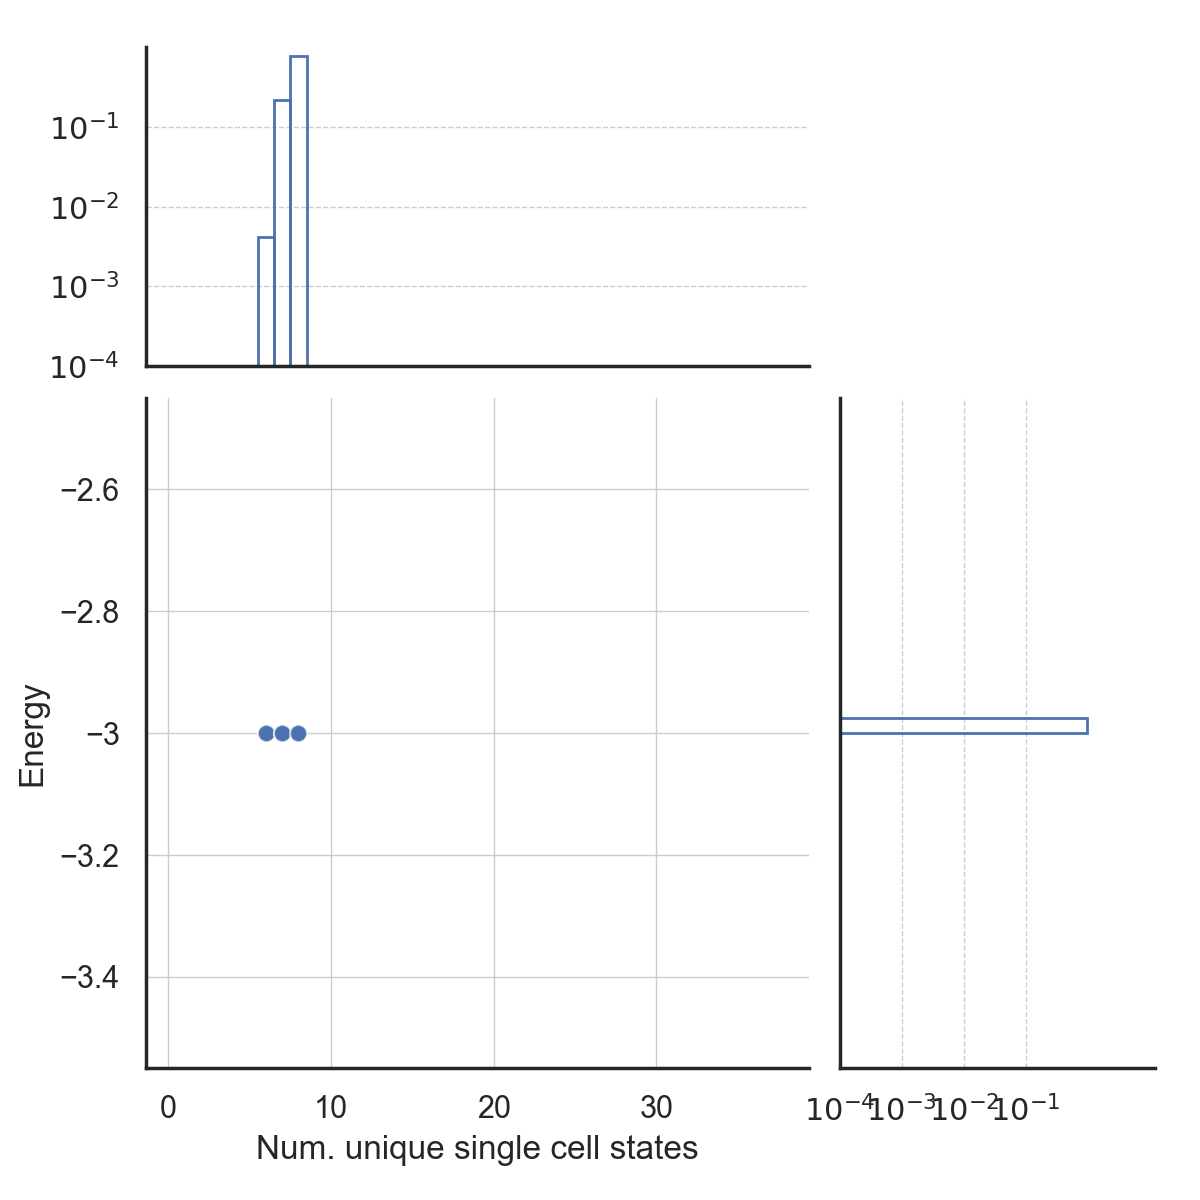

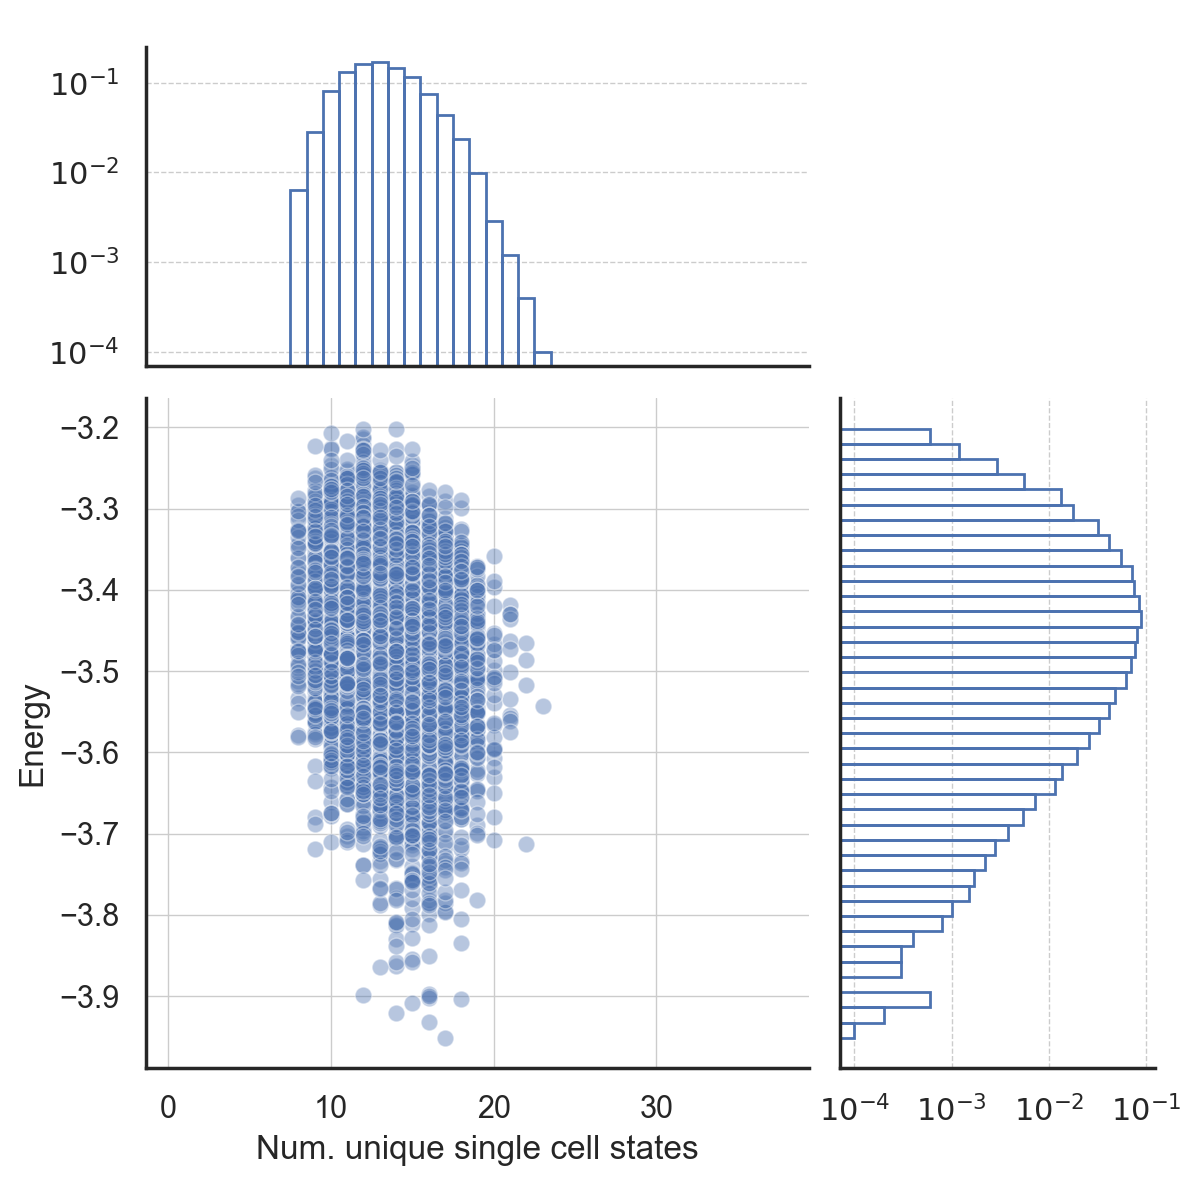

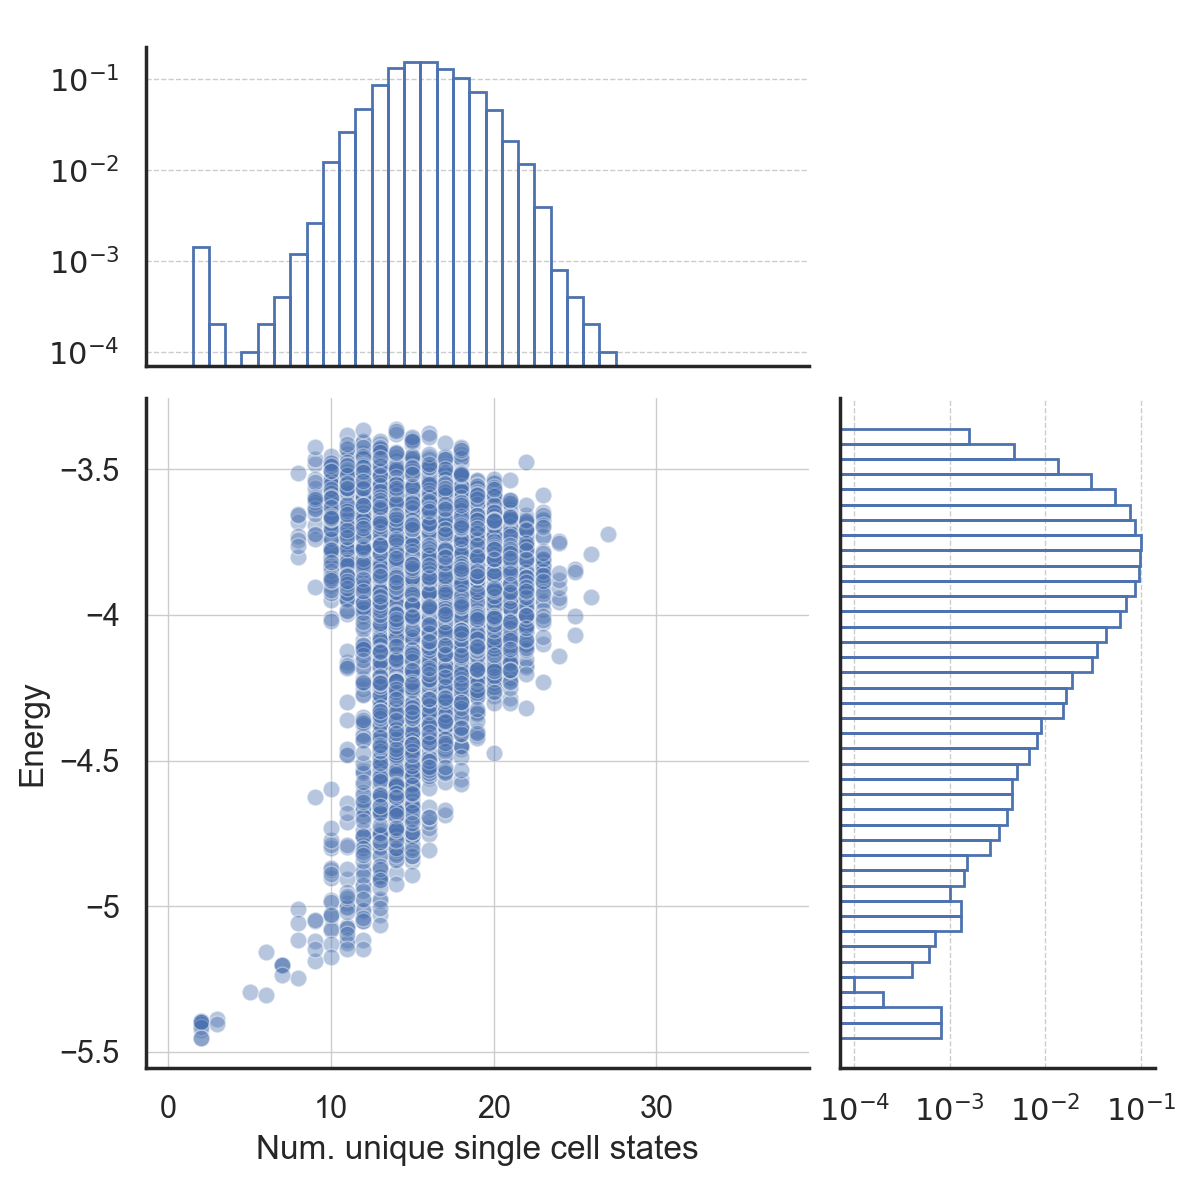

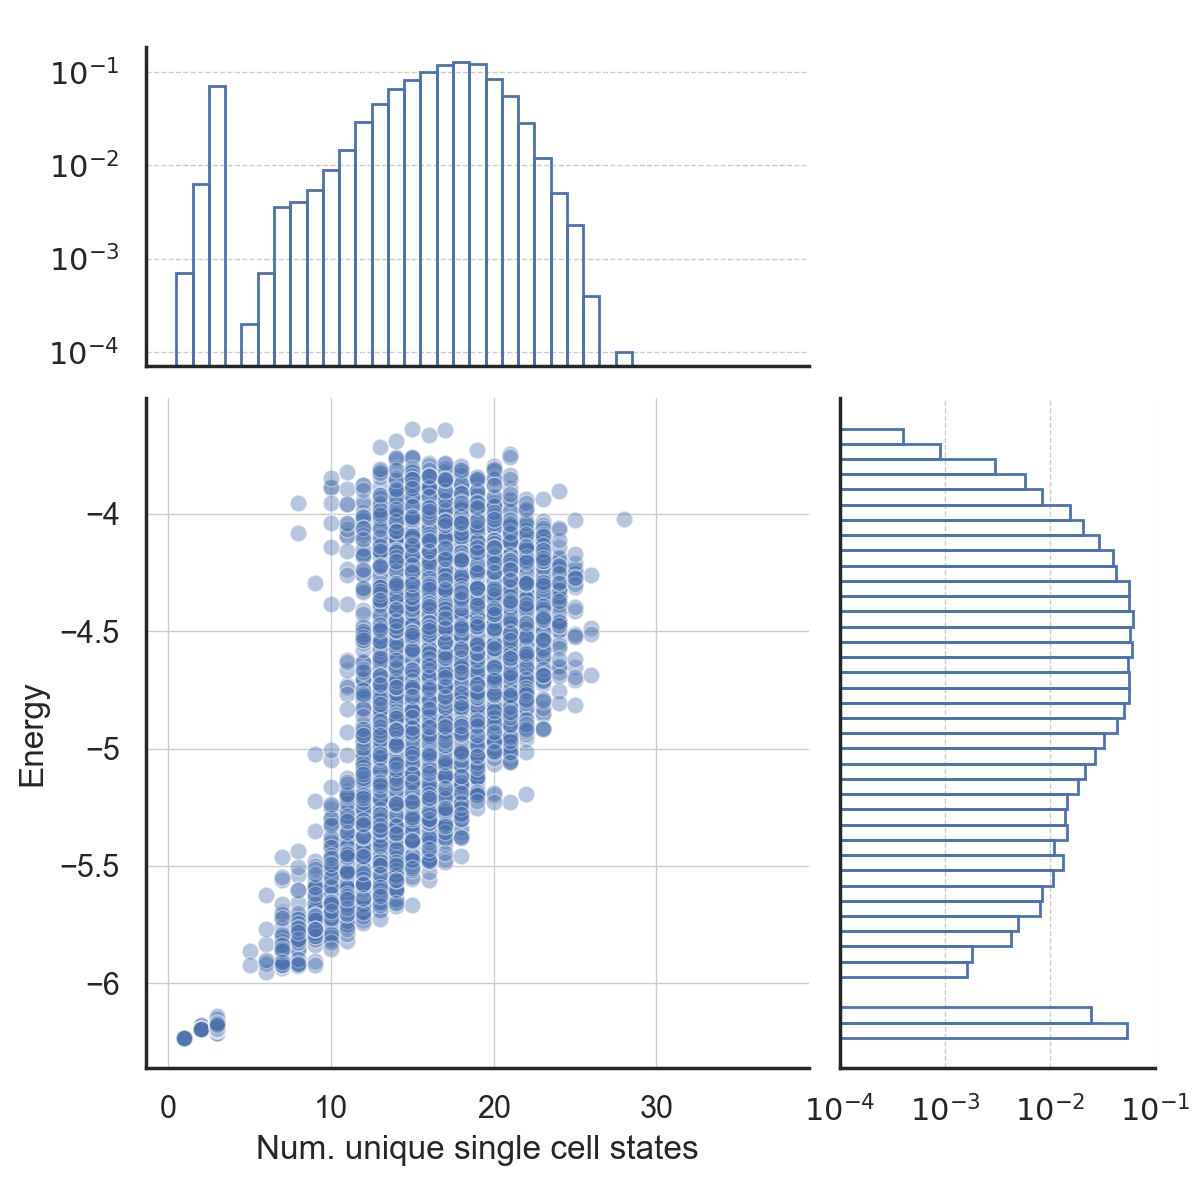

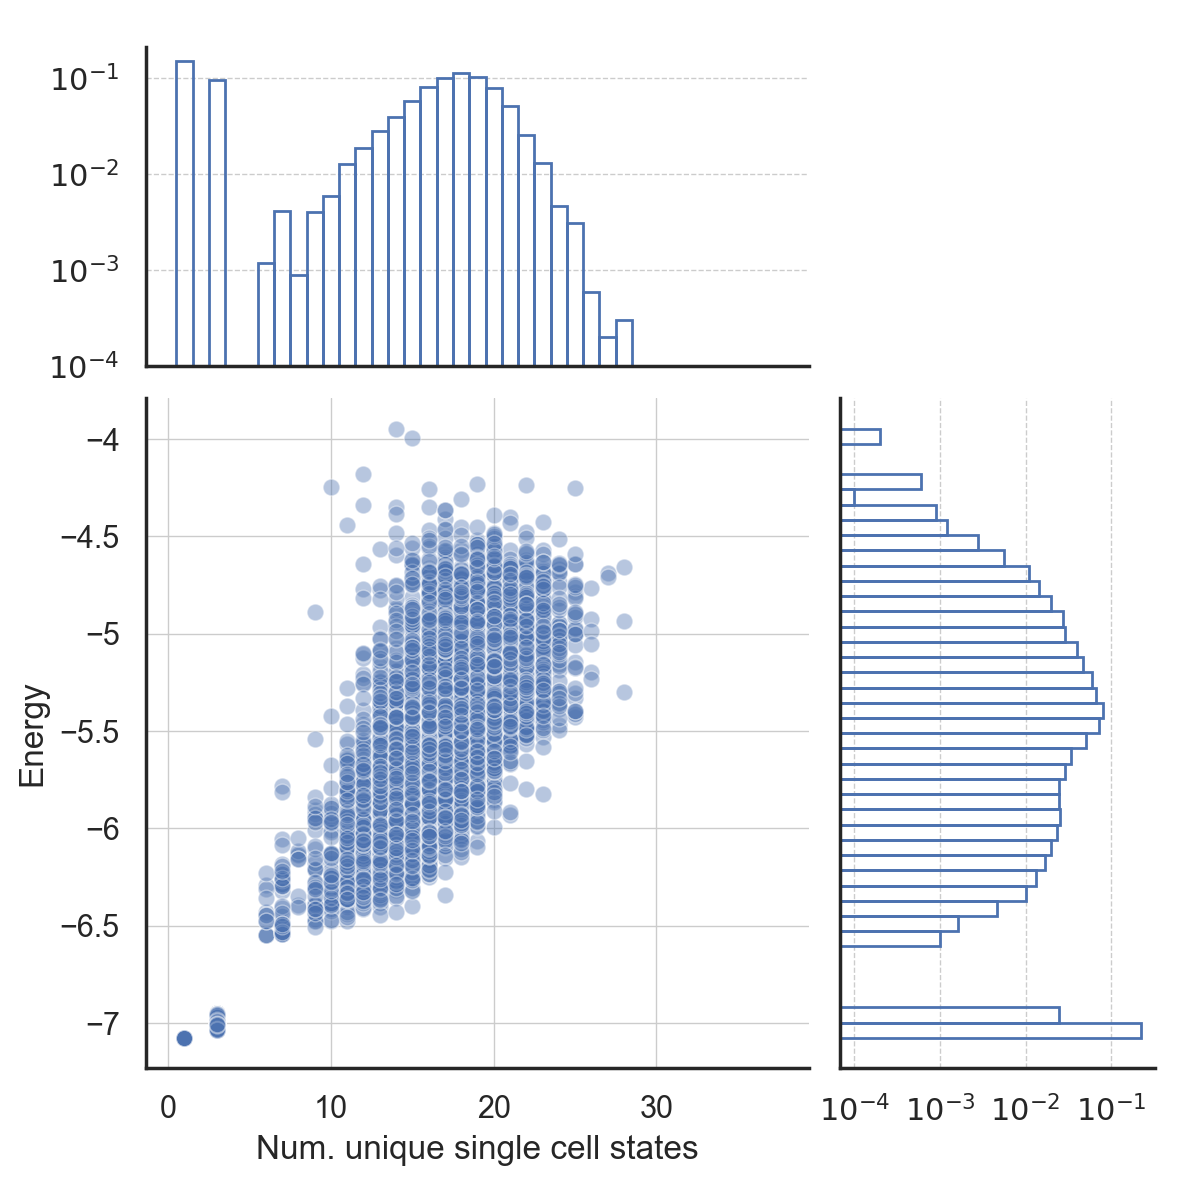

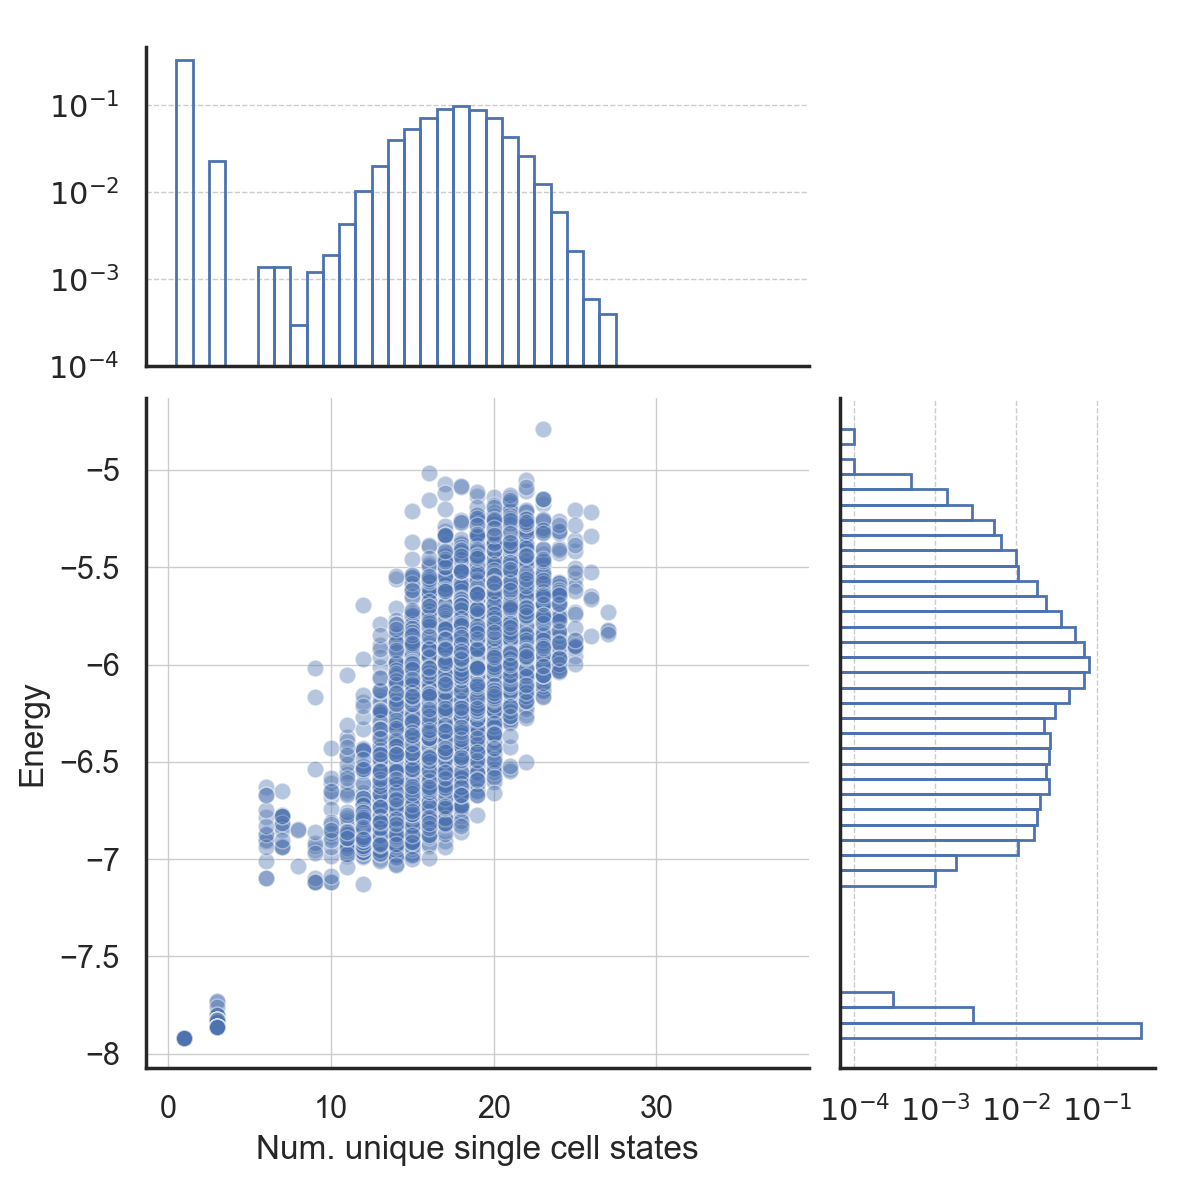

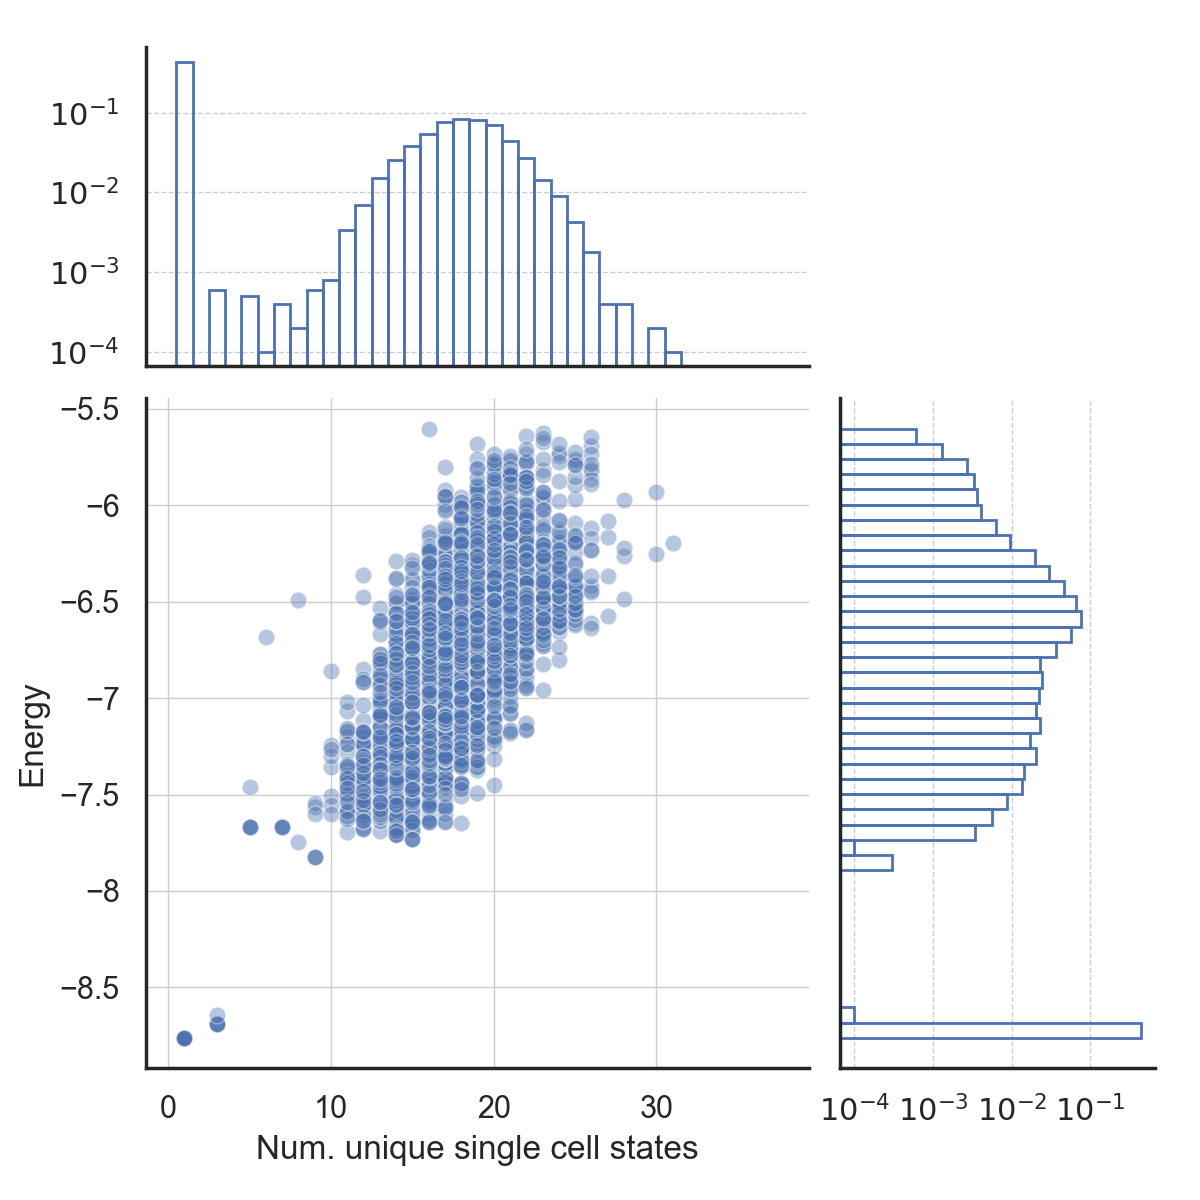

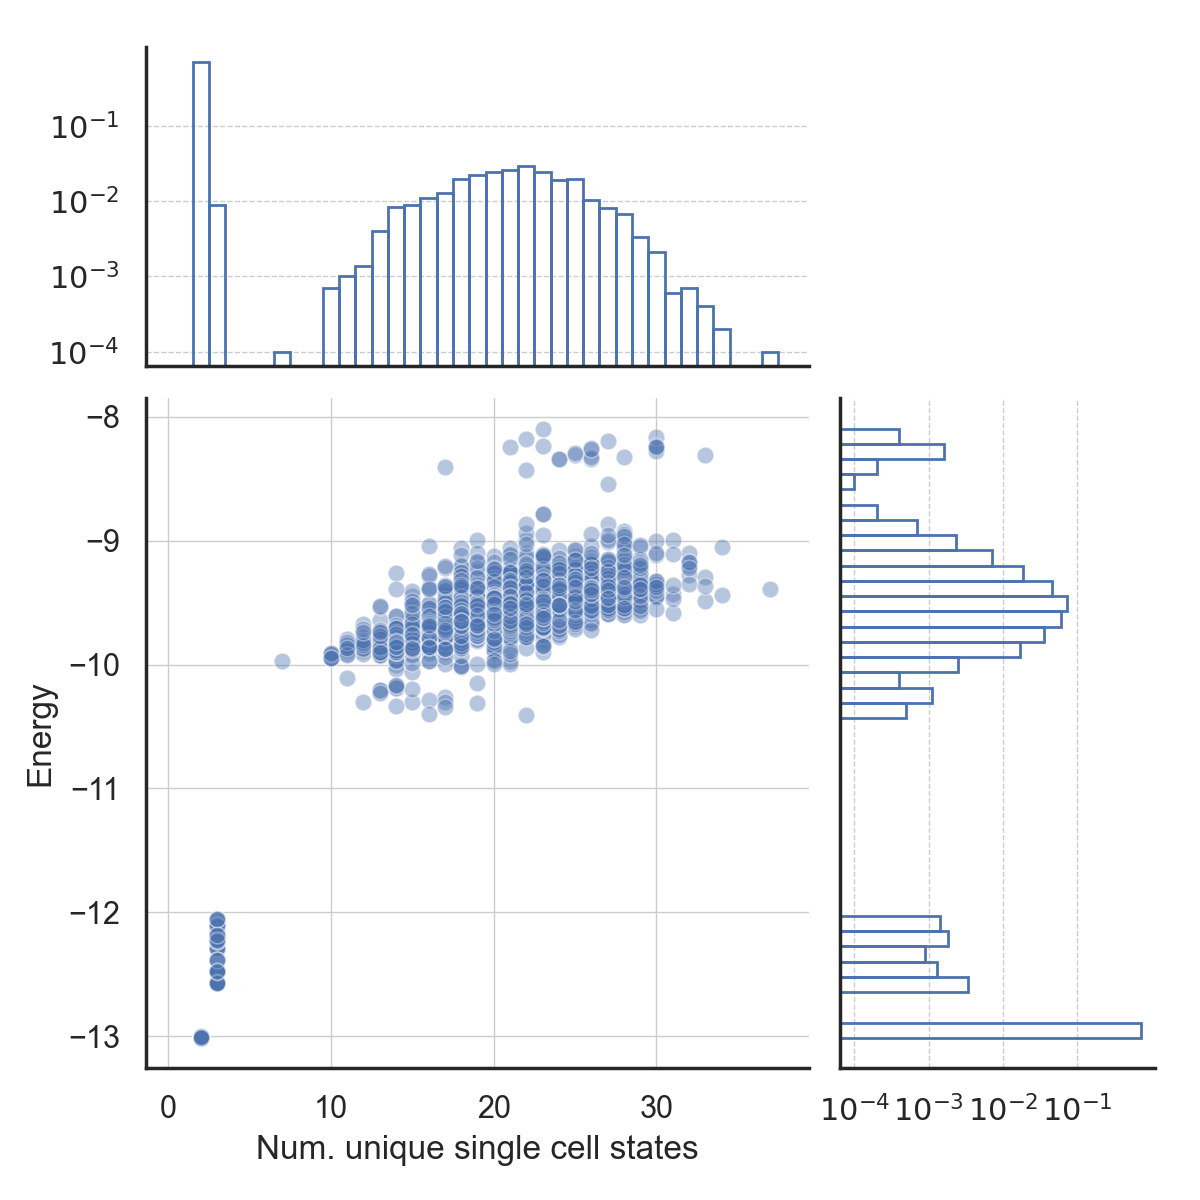

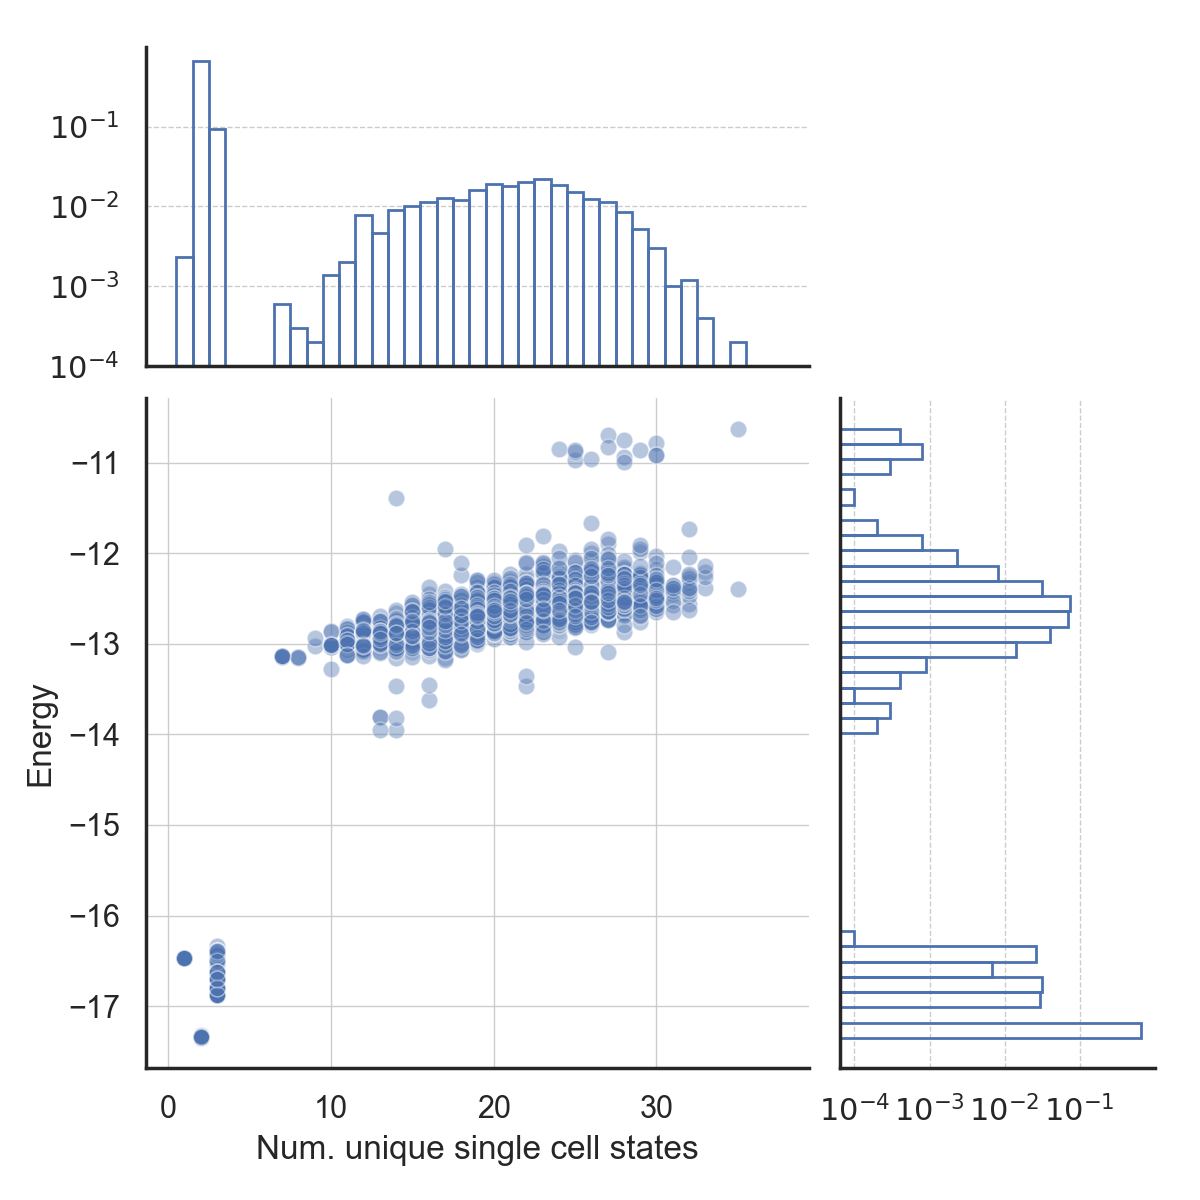

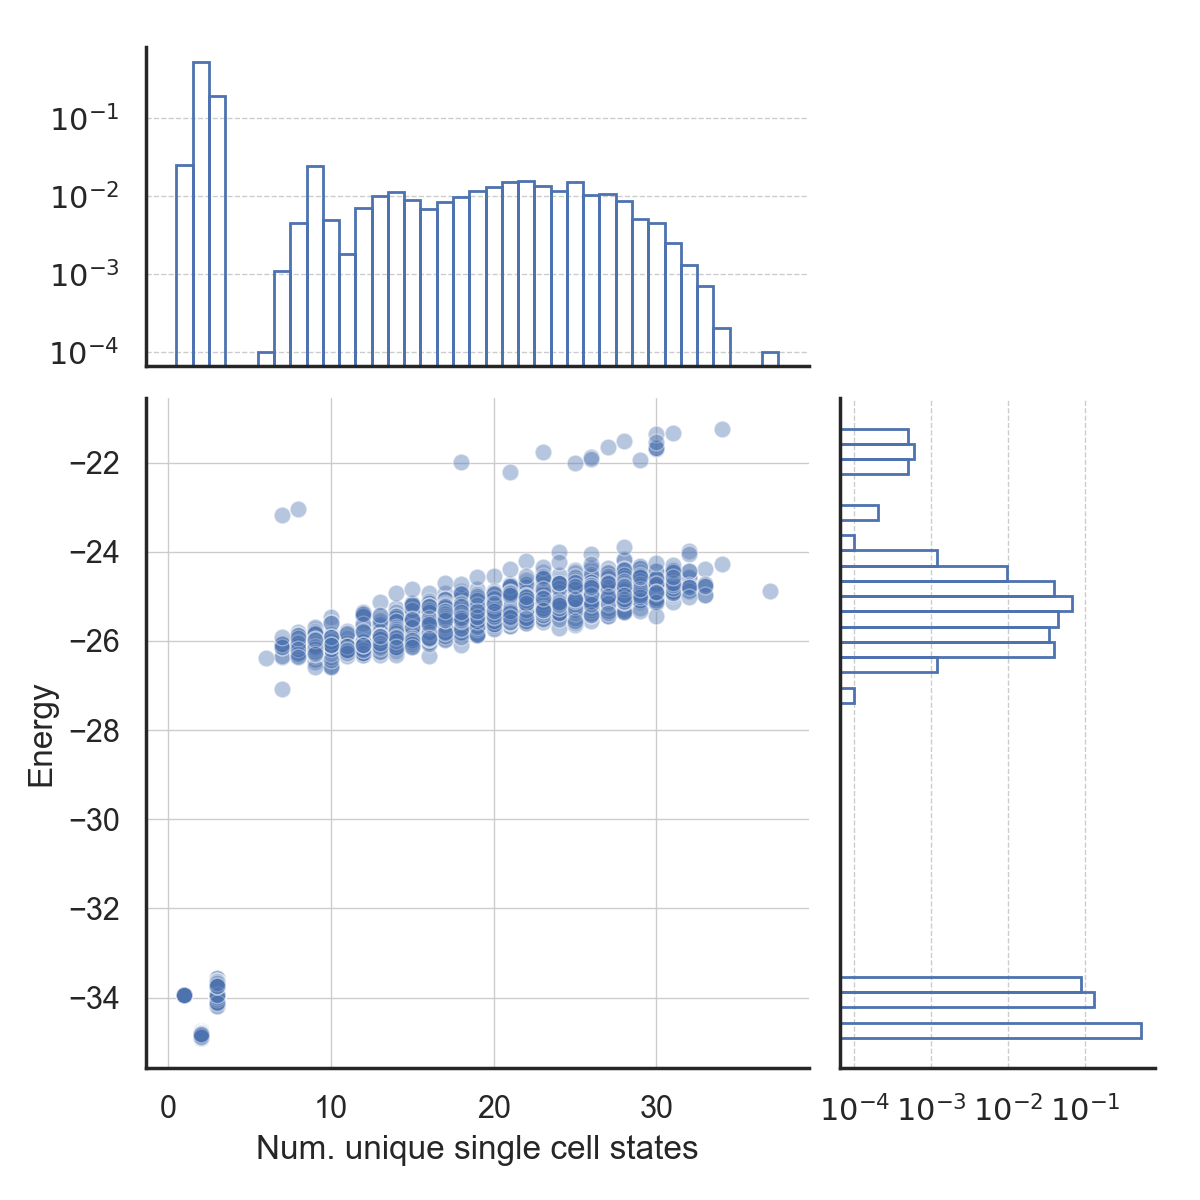

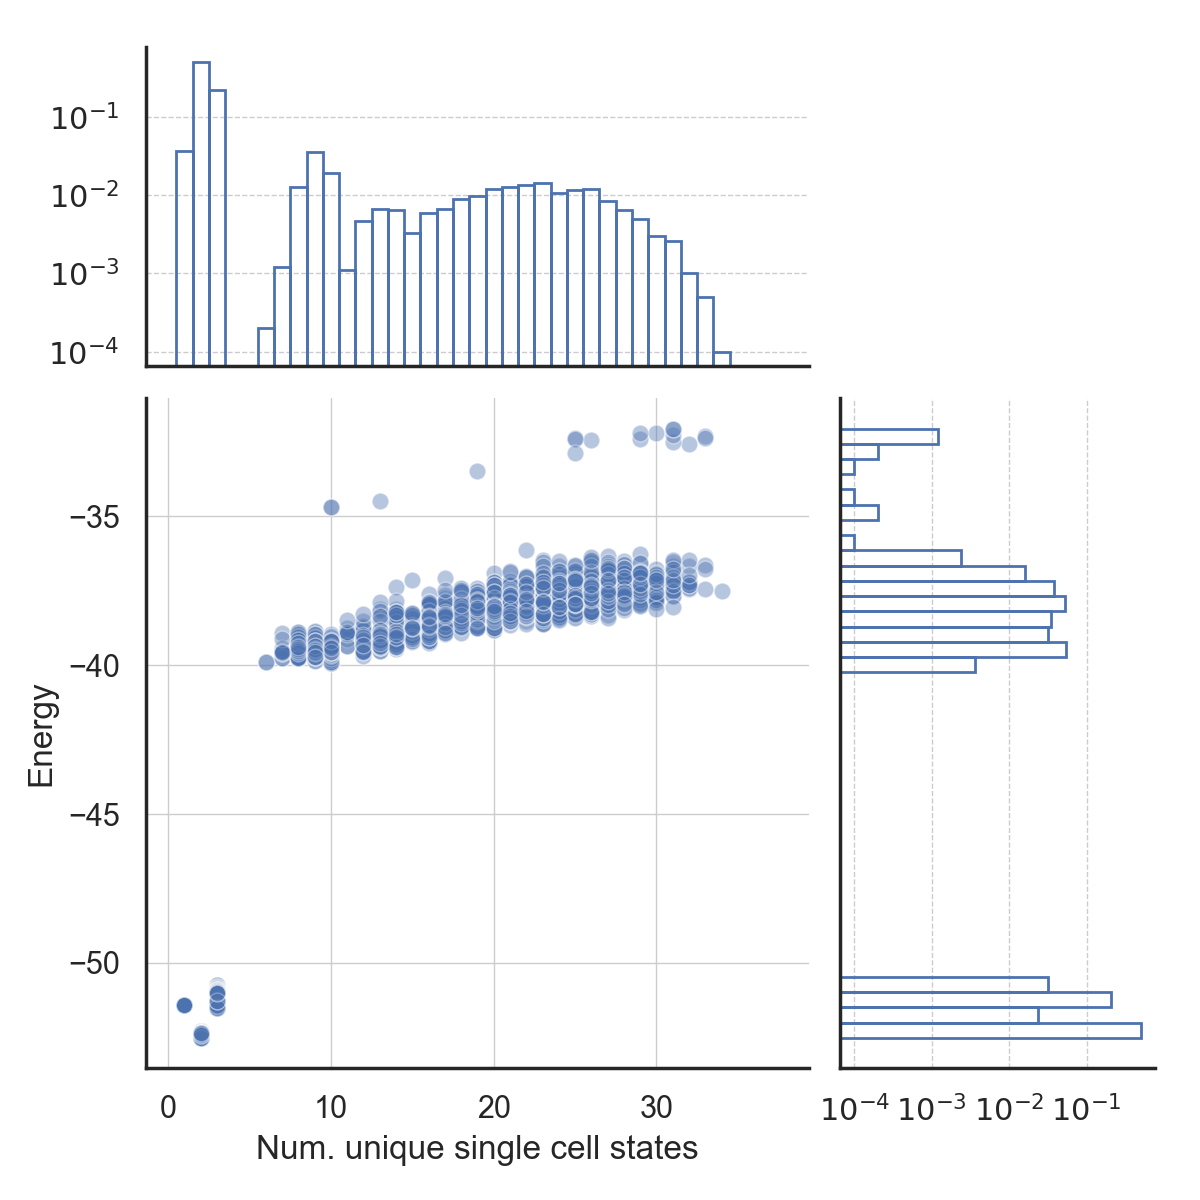

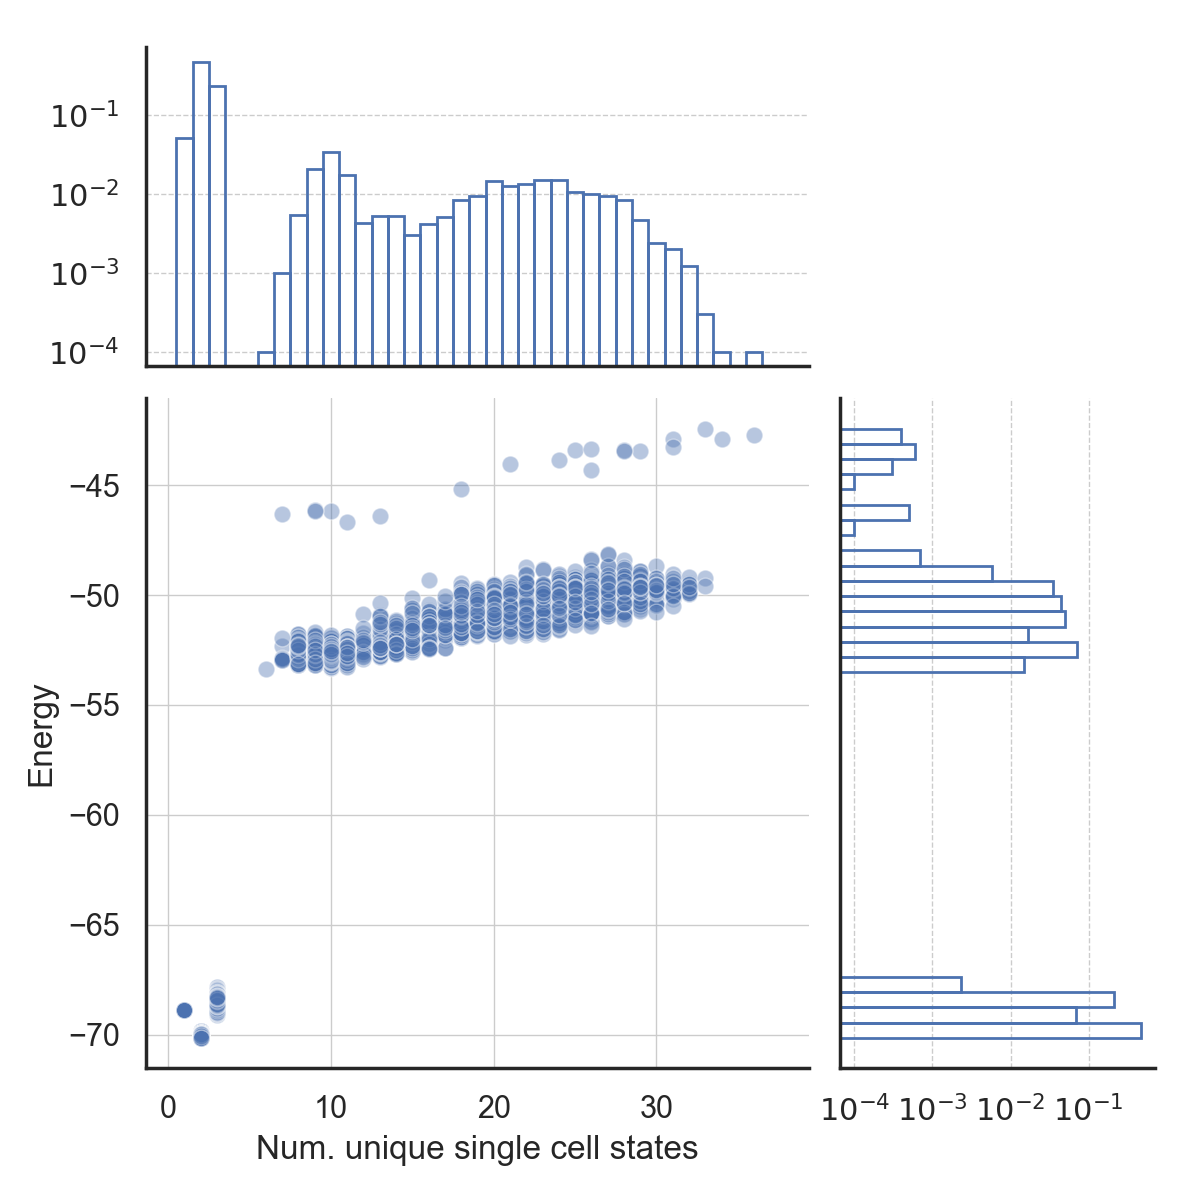

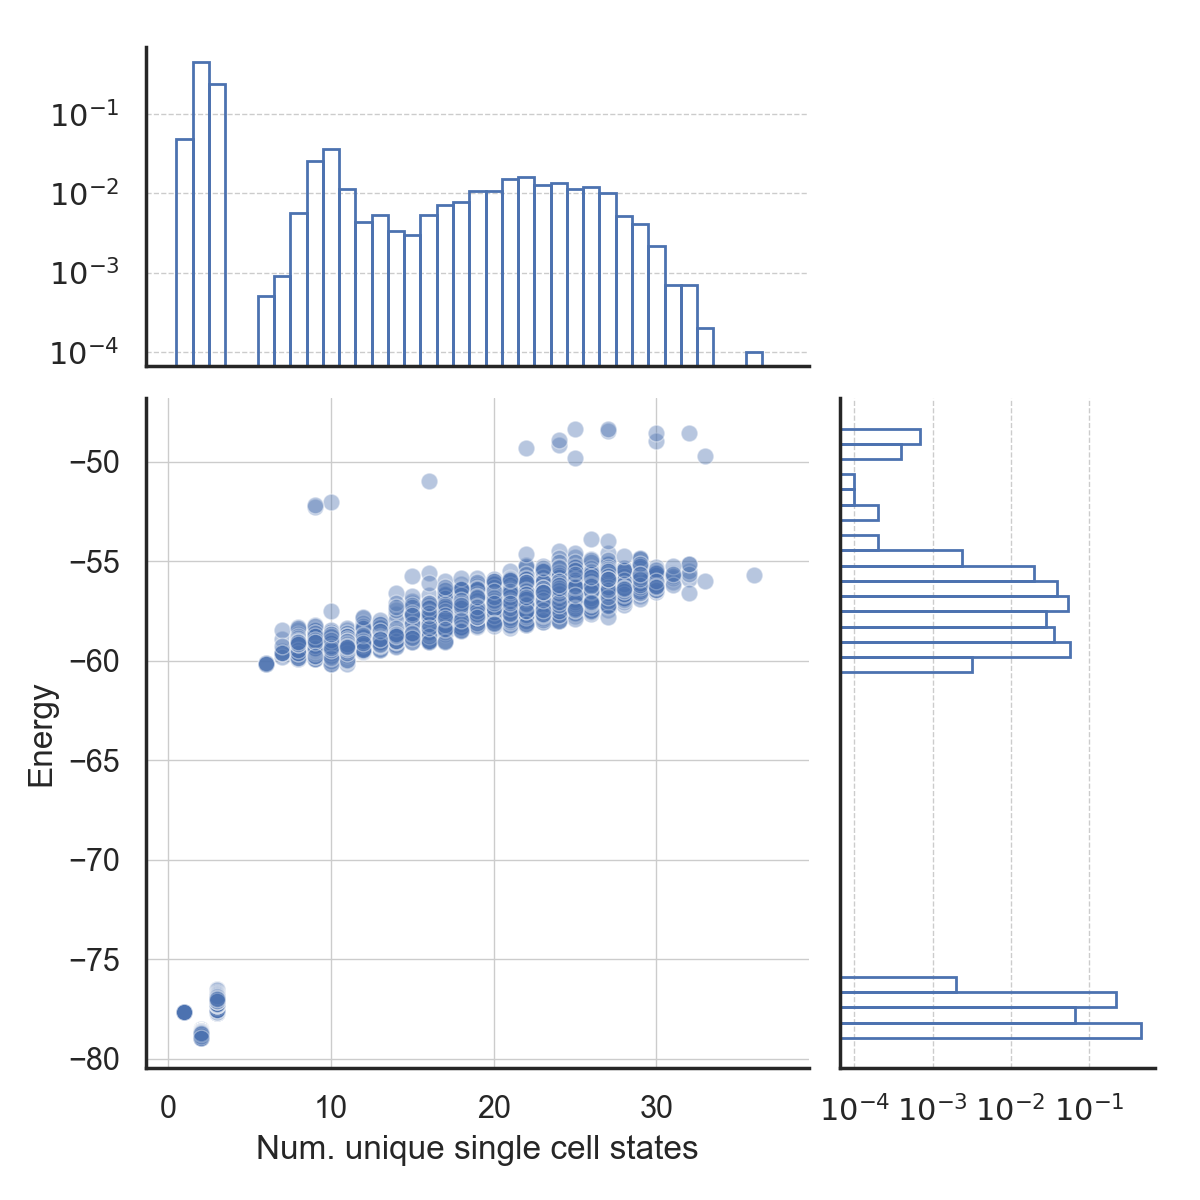

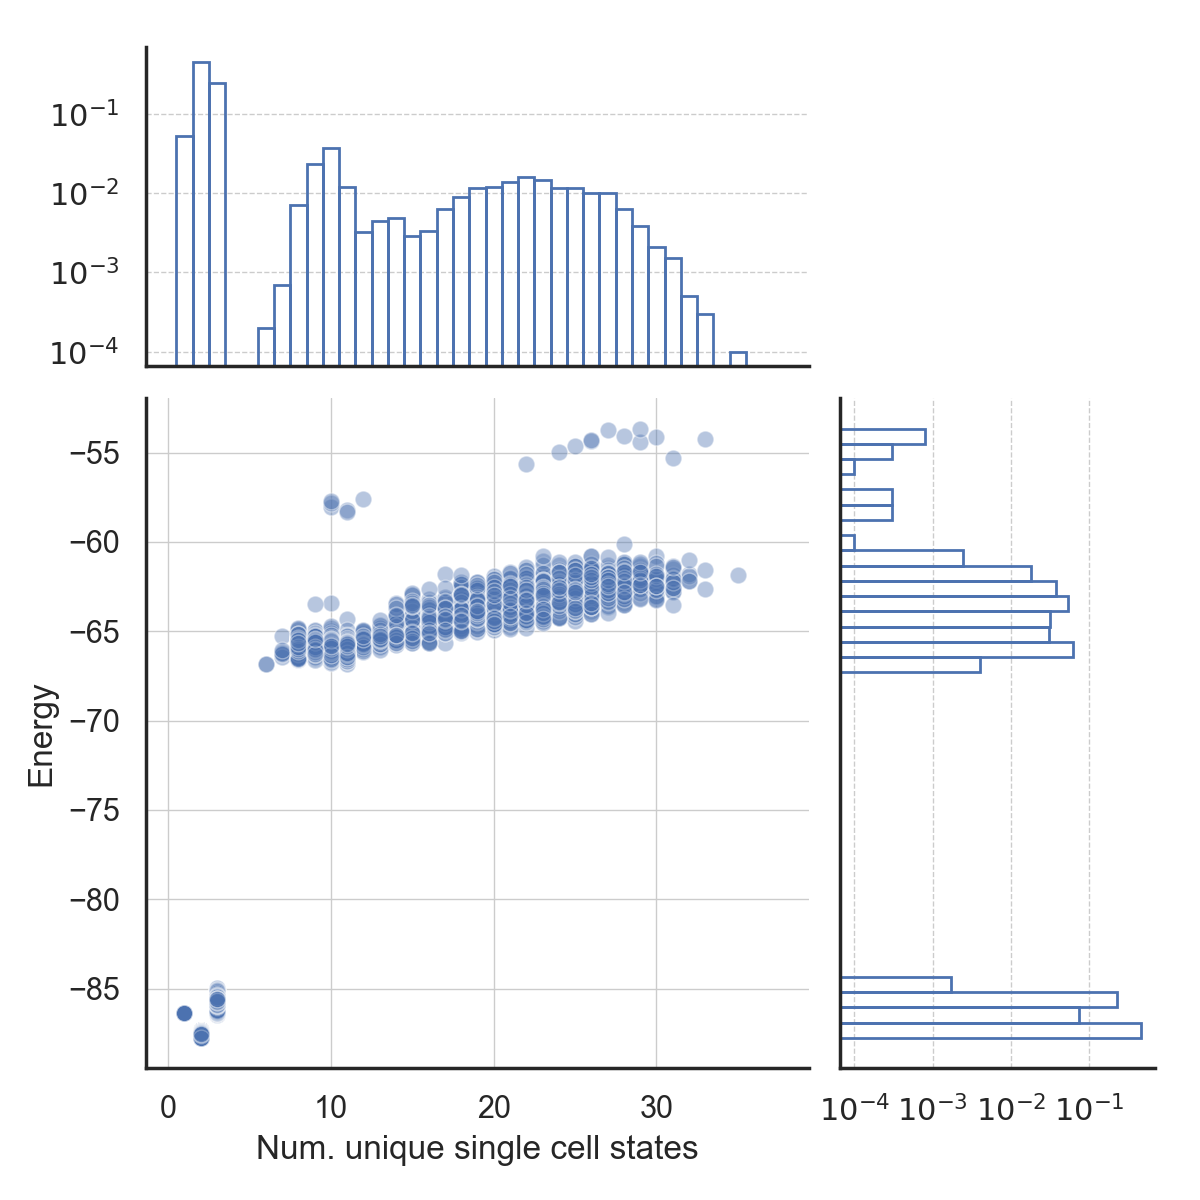

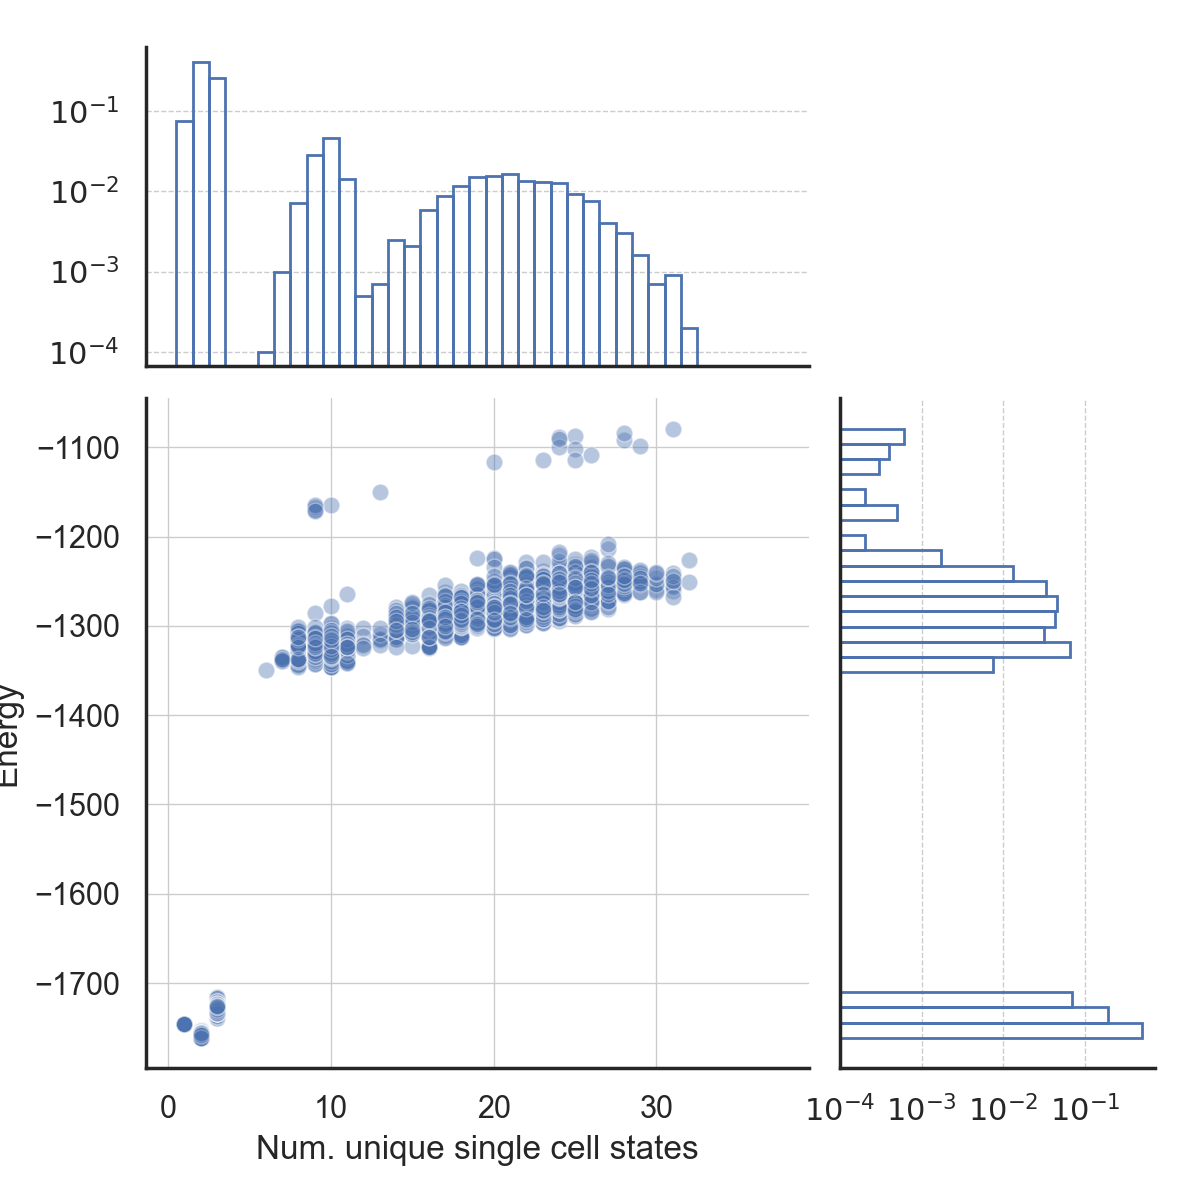

In [324]:
for idx, gamma in enumerate(settings_alignment_chosen['gamma_list']):
    print('Joint plot (energy, nunique) for gamma', idx, gamma, '...')
    jointplot_energy_nunique(idx)

*Correlation: init cond to final state*

*Correlation: energy and spectrum*
- approach 1: rank plot of spectrum; overlay energy values (rescaled) as thin axhline with some alpha
- approach 2: x axis is eigenvalue/rescaled energy, y is frequency -- plot histograms with small bins
- approach 3: check how the observed minima project onto the eigenvectors (part a) 
- approach 3: check how the observed minima project onto the eigenvectors (part b) 
- approach 4: similar to 3, but report the numerical error of the linalg.eig call by showing the magnitude of the projection of all states onto the eigenbasis. the projection coefficients (squared) should sum to ndim=900, but they don't exactly

In [ ]:
from singlecell.singlecell_linalg import sorted_eig

def plot_evals_rank(ax, evals, gamma, eval_indices, zorder=10, x_max=None):
    x_axis = eval_indices  # possible use instead np.arange(len(eval_indices)), and change the axis label
    evals = evals[eval_indices]
    if x_max is not None:
        # given scalar x_stretch, strecth x_axis s.t. x_axis[-1] = x_stretch
        assert eval_indices[0] == 0
        scale_factor = x_max / x_axis[-1]
        x_axis = x_axis * scale_factor
    ax.plot(x_axis, evals, '--o', c='k', alpha=0.6, label='$\gamma=%.2f$' % gamma, zorder=zorder)
    ax.axhline(0)
    
def plot_evals_hist(ax, evals, gamma, nbins=120, zorder=10):
    #plt.scatter(range(len(evals)), evals, marker='o', alpha=0.6, edgecolors='k', label='$\gamma=%.2f$' % gamma)
    ax.hist(evals, alpha=0.6, bins=nbins, label='$\gamma=%.2f$' % gamma, zorder=zorder) 

def get_and_plot_evals(J_multicell, gamma, zorder=10):
    evals, _ = sorted_eig(J_multicell, take_real=True, big_to_small=True)
    #plt.scatter(range(len(evals)), evals, marker='o', alpha=0.6, edgecolors='k', label='$\gamma=%.2f$' % gamma)
    plt.plot(range(len(evals)), evals, '--o', c='k', alpha=0.6, label='$\gamma=%.2f$' % gamma, zorder=zorder)

In [ ]:
#THRESHOLD_A = 0.025  # discard components smaller than this
THRESHOLD_B = 0.975    # def 0.99; alternative: add components until we get to this value

In [ ]:
def compare_energy_and_spectra(gamma_idx, approach=1):
    assert approach in [1, 2, 3, 4, 5]
    
    gamma_val = settings_alignment_chosen['gamma_list'][gamma_idx]
    multicell = embedded_datasets[gamma_idx]['multicell_template']
    states = embedded_datasets[gamma_idx]['data']
    J_multicell = multicell.matrix_J_multicell
    ndim = J_multicell.shape[0]
    rescaling_constant = - 2.0 / multicell.num_genes

    # get spectrum of J_multicell
    force_symm = False
    if force_symm:
        J_multicell = 0.5 * (J_multicell.T + J_multicell)
    evals, evecs = sorted_eig(J_multicell, take_real=True, big_to_small=True)
    eval_indices =  np.arange(len(evals))
    print('states.shape', states.shape)
    print('evecs.shape', evecs.shape)
    
    # rescale energies
    npts = embedded_datasets[gamma_idx]['energies'].shape[0]
    energy_rescaled = embedded_datasets[gamma_idx]['energies'][:, 0] * rescaling_constant
    
    plt.figure(figsize=(6.5, 6.5))
    ax = plt.gca()
    misc_output = None
    
    if approach == 1:
        xlim_max = 900
        plot_evals_rank(ax, evals, gamma_val, eval_indices, x_max=xlim_max)
        plt.axhline(0, color='k', linestyle='--')
        
        """
        # plot rescaled emergy
        for k in range(npts):
            plt.axhline(energy_rescaled[k], alpha=0.4, linewidth=0.1, zorder=1)

        ax.set_xlabel(r'Rank of $\lambda$')
        ax.set_ylabel(r'$\lambda$')
        plt.title(r'Rescaled energy $-2/N \cdot E(x)$ vs. spectrum for $\gamma=%.2f$ (idx %d)' % 
                  (settings_alignment_chosen['gamma_list'][gamma_idx], gamma_idx))
        plt.xlim(0,60)
        #plt.xlim(0,25)
        plt.ylim(np.min(energy_rescaled) * 0.95, np.max(evals) * 1.05)
        #plt.gcf().set_figheight(5.5); plt.gcf().set_figwidth(5.5)
        """
        # plot rescaled emergy histogram        
        plt.hist(energy_rescaled, 
                 alpha=0.75, bins=40, label='$-2/N \cdot E(x)$, $\gamma=%.2f$' % gamma_val, 
                 color='blue', zorder=5, lw=0.5, density=False,
                 log=False, 
                 orientation='horizontal')
        ax.set_xlabel(r'Rank of $\lambda$ (and rescaled energy $-2/N \cdot E(x)$ bin height)')
        ax.set_ylabel(r'$\lambda$')
        
        #ax.set_yscale('log')
        #plt.xlim(0, 900)
        
        plt.xlim(0, 50)
        plt.ylim(1, 2.5)
        ax.legend()
        
    elif approach == 2:
        plt.hist(evals, 
                 alpha=0.75, bins=100, label='Spectrum, $\gamma=%.2f$' % gamma_val, 
                 color='k', zorder=10, lw=0.5, density=False)
        plt.hist(energy_rescaled, 
                 alpha=0.75, bins=40, label='$-2/N \cdot E(x)$, $\gamma=%.2f$' % gamma_val, 
                 color='blue', zorder=5, lw=0.5, density=False)
        ax.set_xlabel(r'$\lambda$')
        ax.set_xlabel(r'$\lambda$')
        #ax.set_ylabel('Observations')
        ax.set_yscale('log')
        ax.legend()
    elif approach == 3:
        for k in range(5):
            proj = np.dot(states[k, :], evecs)  # care transpose, eigenvectors are the columns of the array
            proj_normed = proj ** 2 / ndim
            
            eval_indices_descending = np.argsort(proj_normed)[::-1]
            proj_normed_sorted = proj_normed[eval_indices_descending]
            xaxis = [str(a) for a in eval_indices_descending]
            
            plt.bar(xaxis, proj_normed_sorted, alpha=0.6)
            print('Check magnitude of projection coefficients for state %d:' % k, np.dot(proj, proj))
            plt.xlim(0,40)
            plt.xlabel(r'Rank $i$ of $\lambda_i$')
            plt.ylabel(r'Projection coefficient $\frac{1}{NM} c_i^2$')
            plt.title('State index: %d' %k)
            plt.show()

    elif approach == 4:
        # how to decide on threshold? when the sgn(sum c_i v_i) ======= the state with high probability

        # Step 1: compute num_components and validation array (both len npts)
        num_components = np.zeros(npts, dtype=int)
        state_reconstructed = np.zeros(npts, dtype=int)
        
        all_proj = np.dot(states, evecs)  # care transpose, eigenvectors are the columns of the array
        all_proj_normed = all_proj ** 2 / ndim
        
        npts_4 = 10000
        assert npts_4 == npts
        
        for k in range(npts_4):
            #proj = np.dot(states[k, :], evecs)  # care transpose, eigenvectors are the columns of the array
            #proj_normed = proj ** 2 / ndim
            proj = all_proj[k, :]
            proj_normed = all_proj_normed[k, :]
            
            eval_indices_descending = np.argsort(proj_normed)[::-1]
            proj_normed_sorted = proj_normed[eval_indices_descending]
            
            # Using 'threshold type B':
            proj_normed_sorted_cumsum = np.cumsum(proj_normed_sorted)
            threshold_index = np.searchsorted(proj_normed_sorted_cumsum,
                                              THRESHOLD_B)
            num_components[k] = threshold_index + 1
            #print(np.sum(proj_normed_sorted[0:threshold_index]))
            #print('vs', np.sum(proj_normed_sorted[0:threshold_index+1]))
            #print(k, num_components[k])
            
            # Check if this is able to 'reconstruct' the state
            eval_indices_desc_trunc = eval_indices_descending[0:num_components[k]]
            
            reconstruction_thresholded = np.sum(proj[eval_indices_desc_trunc] * evecs[:, eval_indices_desc_trunc], axis=1)
            error_arr = states[k, :] - np.sign(reconstruction_thresholded)
            if np.all(error_arr == 0):
                state_reconstructed[k] = 1
            else:
                print('FAIL', set(error_arr), np.count_nonzero(error_arr))
                
                
            # BUGCHECK DETAILED DATA PLOTS
            """
            if k == 0:
                print('For k = 0 specifically...')
                print('num_components[k]', num_components[k])
                plt.figure(figsize=(10,3))
                im = plt.imshow(evecs[:, eval_indices_desc_trunc])
                print(np.min(evecs[:, eval_indices_desc_trunc]), np.max(evecs[:, eval_indices_desc_trunc]))
                plt.colorbar()
                plt.show()"""
        
        #plt.bar(np.arange(npts), num_components, alpha=0.75, edgecolor='k')
        #plt.xlabel('state index')
        #plt.ylabel('Min. num. components $c_i$ st. $T < \frac{1}{NM} \sum_i c_i^2$ ($T=$%.3f)' % THRESHOLD_B)

        plt.hist(num_components, bins=np.arange(0.5, np.max(num_components) + 0.5), alpha=0.75, edgecolor='k')
        plt.title('Reconstruction of state vector from top $K$ eigenvector components $(\gamma=%.2f)$' % gamma_val)
        plt.ylabel('Observations')
        plt.xlabel('Min. num. of projection components $c_i$ s.t. $T < {NM}^{-1} \sum_i^K c_i^2$ $(T=%.3f)$' % THRESHOLD_B)
        plt.gca().set_yscale('log')
        
        print('%d of %d states reconstructed using THRESHOLD_B = %.3f' % 
              (np.sum(state_reconstructed), npts_4, THRESHOLD_B)
             )
        misc_output = (num_components, state_reconstructed)
        
    else:
        assert approach == 5
        """
        #proj_all = np.dot(states, evecs)
        proj_magnitude = np.linalg.norm(proj_all, axis=1)**2
        errors = ndim - proj_magnitude
        plt.bar(np.arange(npts), errors, alpha=0.75, edgecolor='k')
        plt.axhline(0)"""      
        
        norms = np.linalg.norm(evecs, axis=0)**2
        plt.bar(np.arange(ndim), 1 - norms, alpha=0.75, edgecolor='k')
        plt.axhline(0)
        plt.xlabel(r'Evec index')
        plt.ylabel(r'$1 - ||v_i||^2$')

    #plt.gcf().subplots_adjust(left=0.1)
    plt.savefig(NOTEBOOK_OUTDIR + os.sep + 'compare_spectrum_energy_gamma%.2f_%d_approach%d.pdf' % 
                (gamma_val, gamma_idx, approach),
               bbox_inches='tight')
    return ax, misc_output

In [ ]:
gamma_idx = 7  # idx 13 is gamma 1.0; idx 9 is gamma 0.4
gamma_val = settings_alignment_chosen['gamma_list'][gamma_idx]
print(gamma_val)

In [ ]:
ax = compare_energy_and_spectra(gamma_idx, approach=1)
plt.show()

In [ ]:
ax = compare_energy_and_spectra(gamma_idx, approach=2)
plt.show()

In [ ]:
ax = compare_energy_and_spectra(gamma_idx, approach=3)
plt.show()

In [ ]:
ax, misc_output = compare_energy_and_spectra(gamma_idx, approach=4)
#plt.show()

In [ ]:
num_components = misc_output[0]
state_reconstructed = misc_output[1]

plt.figure(figsize=(6.5, 6.5))
plt.hist(num_components, bins=np.arange(0.5, np.max(num_components) + 0.5), alpha=0.75, edgecolor='k')
plt.title('Reconstruction of state vector from top $K$ eigenvector components $(\gamma=%.2f)$' % gamma_val)
plt.ylabel('Observations')
plt.xlabel('Min. num. of projection components $c_i$ s.t. $T < {NM}^{-1} \sum_i^K c_i^2$ $(T=%.3f)$' % THRESHOLD_B)

#plt.gca().set_yscale('log')
plt.xlim(0,40)

In [ ]:
ax, misc_output = compare_energy_and_spectra(gamma_idx, approach=5)
plt.show()

In [ ]:
#arr = np.eye(3)
arr = np.array([
    [0,1,1],
    [1,1,1],
    [1,0,1]
])


E,V = np.linalg.eig(arr)
print(E)
print(V)

print(np.dot(arr, V[:,0]) - E[0] * V[:,0])
print(np.dot(arr, V[0,:]) - E[0] * V[0,:])

## Plot particular state as eigenvector decomposition in lattice format

In [ ]:
def plot_evec_as_lattice(evec, num_cells, num_genes, sidelength, fpath, title=None, norm=True):
    ndim = num_cells * num_genes
    assert sidelength ** 2 == num_cells
    assert len(evec.shape) == 1
    assert evec.shape[0] == ndim
    
    if norm:
        arr_caps = np.amax(np.abs(evec), axis=0)  # could simplify, its not 2D array
        if arr_caps != np.zeros_like(arr_caps):
            evec = evec / arr_caps  # absmax of each eigenvector is stretched to +1    
        vmin = -1.0
        vmax = 1.0
    else:
        vmin = None
        vmax = None
            
    
    # morph array into correct shape (first lattice site has genes 1 to N, next has N+1 to N, etc.)
    sidelength_genes = sidelength * num_genes
    arr = evec.reshape(sidelength, sidelength, num_genes, order='C')
    arr_imshow = np.zeros((sidelength_genes, sidelength))
    for idx in range(sidelength):
        i = num_genes * idx
        j = num_genes * (idx + 1)
        arr_imshow[i:j, :] = arr[idx, :, :].T
    
    plt.figure(figsize=(6,5))
    ax = plt.gca()
    mappable = ax.imshow(arr_imshow, interpolation='none', cmap='coolwarm_r', aspect='auto', 
                         vmin=vmin, vmax=vmax)
    
    # add line dividers for each cell
    vlw = 2.0
    hlw = 2.0
    linecol = 'k'
    for k in range(1, sidelength):
        ax.axvline(k - 0.5, 0, 1, color=linecol, lw=vlw)
        ax.axhline(k * num_genes  - 0.5, 0, 1, color=linecol, lw=hlw)
    
    if title is not None:
        plt.title(title)
    
    plt.savefig(fpath + '.png', bbox_inches='tight')
    plt.savefig(fpath + '.pdf', bbox_inches='tight')
    

def get_spectral_approx_of_state(state_idx, gamma_idx, num_components, show_proj=True):
    gamma_val = settings_alignment_chosen['gamma_list'][gamma_idx]
    multicell = embedded_datasets[gamma_idx]['multicell_template']
    states = embedded_datasets[gamma_idx]['data']
    J_multicell = multicell.matrix_J_multicell
    ndim = J_multicell.shape[0]
    rescaling_constant = - 2.0 / multicell.num_genes

    # get spectrum of J_multicell
    force_symm = False
    if force_symm:
        J_multicell = 0.5 * (J_multicell.T + J_multicell)
    evals, evecs = sorted_eig(J_multicell, take_real=True, big_to_small=True)
    eval_indices =  np.arange(len(evals))
    print('states.shape', states.shape)
    print('evecs.shape', evecs.shape)
    
    # algebra below            
    proj = np.dot(states[state_idx, :], evecs)  # care transpose, eigenvectors are the columns of the array
    proj_normed = proj ** 2 / ndim
    
    eval_indices_descending = np.argsort(proj_normed)[::-1]
    proj_normed_sorted = proj_normed[eval_indices_descending]    
    eval_indices_desc_trunc = eval_indices_descending[0:num_components]

    state_reconstruction = np.sum(proj[eval_indices_desc_trunc] * evecs[:, eval_indices_desc_trunc], axis=1)
    error_state = states[state_idx, :] - np.sign(state_reconstruction)
    
    if np.all(error_state == 0):
        print('Perfectly reconstructed with %d components' % num_components)
    else:
        print('FAIL', set(error_state), 'total gene errors:', np.count_nonzero(error_state))
        
    if show_proj:
        xaxis = [str(a) for a in eval_indices_descending]
        plt.figure(figsize=(10,5))
        plt.bar(xaxis, proj_normed_sorted, alpha=0.6)
        print('Check magnitude of projection coefficients for state %d:' % state_idx, 
              np.dot(proj, proj))
        plt.xlim(-0.5,20)
        plt.xlabel(r'Rank $i$ of $\lambda_i$')
        plt.ylabel(r'Projection coefficient $\frac{1}{NM} c_i^2$')
        plt.title('State index: %d' % state_idx)
        plt.show()
                
    return state_reconstruction, error_state 

In [ ]:
#state_idx = 4854  # 8181 for gamma idx 7; 4854 for gamma idx 5
#gamma_idx = 5

state_idx = 8181  # 8181 for gamma idx 7; 4854 for gamma idx 5
gamma_idx = 7

gamma_val = gamma_list[gamma_idx]

num_cells = 100
num_genes = 9
sidelength = 10

outdir = NOTEBOOK_OUTDIR + os.sep + 'tissue_g%.3f_agg%d_spectralproj' % (gamma_val, state_idx)
os.makedirs(outdir, exist_ok=True)
print('gamma_val:', gamma_val)

####  Plot true state in fancy format

In [ ]:
data_subdict = embedded_datasets[gamma_idx]   
title = 'Point: %d' % state_idx  # None
plot_tissue_given_agg_idx(
    data_subdict, state_idx, fmod, outdir, 
    state_int=False, smod_last=smod, title=title)
print('plotted tissue in %s' % outdir)

#### Approximate the state using top-k eigenvector weighted sum

In [ ]:
state_true = data_subdict['data'][state_idx, :]

num_components = 2  # how many evecs to include in reconstruction

In [ ]:
state_reconstruction, reconstruction_error = get_spectral_approx_of_state(
    state_idx, gamma_idx, num_components)

In [ ]:
title = 'True state %d for $\gamma=%0.3f$' % (state_idx, gamma_val)
plot_evec_as_lattice(state_true, num_cells, num_genes, sidelength, 
                     outdir + os.sep + 'truestate',
                     norm=True,
                     title=title)

In [ ]:
title = 'Approx. state %d for $\gamma=%0.3f$ (components: %d)' % (state_idx, gamma_val, num_components)
plot_evec_as_lattice(state_reconstruction, num_cells, num_genes, sidelength, 
                     outdir + os.sep + 'ncomponents%d_stateapprox' % num_components,
                     norm=True,
                     title=title)

In [ ]:
title = 'Approx. state (signed) %d for $\gamma=%0.3f$ (components: %d)' % (state_idx, gamma_val, num_components)
plot_evec_as_lattice(np.sign(state_reconstruction), num_cells, num_genes, sidelength, 
                     outdir + os.sep + 'ncomponents%d_stateapproxSigned' % num_components,
                     norm=True,
                     title=title)

In [ ]:
title = 'Approximation error for state %d for $\gamma=%0.3f$ (components: %d)' % (state_idx, gamma_val, num_components)
plot_evec_as_lattice(reconstruction_error, num_cells, num_genes, sidelength, 
                     outdir + os.sep + 'ncomponents%d_stateapprox_error' % num_components,
                     norm=True,
                     title=title)

# Testing code for plotting

**Plotting num unique cell states -- special discrete cmap**

Consider also using different markerstyles (triangle, square, etc.) for different nunique

In [ ]:
sns.color_palette("hls", 8)

In [ ]:
sns.color_palette('pastel')

In [ ]:
sns.color_palette()

In [ ]:
X = data_subdict_gamma0['data']
print(X.shape)
print(X[7299,0:9])

In [ ]:
agg = 7299
aggstate = X[agg, :]

In [ ]:
aggstate_reshape_F = aggstate.reshape((9,100), order='F')
aggstate_reshape = aggstate.reshape((9,100), order='C')

replot_scatter_dots_TEST(
    aggstate_reshape, 10, outpath,
    fmod='_bugfmodSpecific_reshapeF', 
    state_int=True, title='bug? %s %d' % (fname, agg))

replot_scatter_dots_TEST(
    aggstate_reshape, 10, outpath,
    fmod='_bugfmodSpecific_reshapeC', 
    state_int=True, title='bug? %s %d' % (fname, agg))

In [ ]:
print(X.shape)

In [ ]:
rrr = np.random.rand(4,4)
print(rrr)

In [ ]:
current = rrr[:, 3]
current = current.reshape((2, 2), order='F') 
current = reshape_totalspins(current, 2, 2)
print(current)
print(rrr)

In [ ]:
X = np.array([
    1,1,1,
    2,2,2,
    1,1,1,
    3,4,3
])
print(reshape_totalspins(X, 4, 3))
tissue_to_num_unique_cells(X, 4, 3)

In [ ]:
embedded_datasets_rerun = add_PCA_to_embedded_datasets({0: data_subdict_being_used})

In [ ]:
# full: (5, 3.5)
# inset with xlim(0,25): (2.5, 2.5)
fig = plt.figure(figsize=(5, 3.5), dpi=450)
for idx in [0]:
    gamma_val = 0.0
    data_subdict_selected = embedded_datasets_rerun[idx]
    pca_dict = data_subdict_selected['algos']['pca']
    plt.plot(
        pca_dict['cumsum_x'], 
        pca_dict['cumsum_y'], 
        '--',
        label=r'$\gamma=%.2f$' % gamma_val)

plt.axvline(300, linestyle='-.', c='k', zorder=1)    

# axis modifications
#plt.gca().set_xscale('log')
#plt.gca().set_yscale('log')
#plt.xlim(0,25)

#plt.legend()
plt.xlabel('Num. components')
plt.ylabel('Cumulative sum of eigenvalues')

#plt.gcf().subplots_adjust(bottom=0.25, left=0.25)
fpath_pca_cumsum = NOTEBOOK_OUTDIR + os.sep + 'pca_modded_alt'
plt.gcf().subplots_adjust(bottom=0.15, left=0.25)
plt.savefig(fpath_pca_cumsum + '.svg')
plt.savefig(fpath_pca_cumsum + '.pdf')
plt.show()